In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('Set2')
import time

from sklearn.impute import KNNImputer
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.model_selection import (train_test_split, KFold, GridSearchCV)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                                accuracy_score, precision_score, recall_score, f1_score,
                                roc_auc_score, roc_curve, auc, precision_recall_curve)

## Data Load

In [76]:
def read_data(path_data):
    return pd.read_csv(path_data)

In [77]:
# Hàm xóa Feature
def drop_column(data, column):
    data.drop(column, axis = 1, inplace = True)
    return data

In [78]:
# Truy vấn các Feature theo kiểu dữ liệu `dtype`
def _select_dtypes_(data, dtype):
    value = data.select_dtypes(include=[dtype])
    name_columns = data.select_dtypes(include=[dtype]).columns
    return name_columns, value

In [79]:
train_data = read_data("application_train.csv")
print("Training data shape:", train_data.shape)

Training data shape: (307511, 122)


## Mô tả bộ dữ liệu

In [80]:
train_data.rename(columns={'TARGET': 'label'}, inplace=True)
drop_column(train_data, ['SK_ID_CURR','CODE_GENDER'])
train_data.head()

label NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      1         Cash loans            N               Y             0   
1      0         Cash loans            N               N             0   
2      0    Revolving loans            Y               Y             0   
3      0         Cash loans            N               Y             0   
4      0         Cash loans            N               Y             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
0          202500.0    406597.5      24700.5         351000.0   Unaccompanied   
1          270000.0   1293502.5      35698.5        1129500.0          Family   
2           67500.0    135000.0       6750.0         135000.0   Unaccompanied   
3          135000.0    312682.5      29686.5         297000.0   Unaccompanied   
4          121500.0    513000.0      21865.5         513000.0   Unaccompanied   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 120 columns]

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 120 entries, label to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(15)
memory usage: 281.5+ MB


> Bộ dữ liệu của có các đặc điểm sau:

- Số lượng quan sát: 307,511
- Số lượng Feature: 122
- Biến mục tiêu: `label`

> Loại dữ liệu:
- Số thực (float64): 65 cột
- Số nguyên (int64): 41 cột
- Chuỗi/Đối tượng (object): 16 cột

> **Các Feature có thể hiện các thông tin bao gồm:**

1. Thông Tin Cá Nhân
2. Thông Tin Tài Chính
3. Thông Tin về Khoản Vay
4. Thông Tin Liên Quan Đến Gia Đình
5. Thông Tin Liên Quan Đến Việc Làm
6. Thông Tin Về Lịch Sử Tín Dụng

> **Một số Feature cần chú ý bao gồm:**

- `SK_ID_CURR`: ID duy nhất cho mỗi hồ sơ vay.
- `TARGET:` Biến mục tiêu, thường chỉ ra liệu khoản vay có bị vỡ nợ hay không (1 có thể nghĩa là vỡ nợ, 0 nghĩa là không).
- `NAME_CONTRACT_TYPE:` Loại hợp đồng khoản vay (ví dụ: vay tiền mặt, vay quay vòng).
- `WEEKDAY_APPR_PROCESS_START:` Ngày trong tuần người vay nộp đơn.
- `CODE_GENDER:` Giới tính của người vay.
- `FLAG_OWN_CAR:` Chỉ ra liệu người vay có sở hữu xe hơi hay không.
- `FLAG_OWN_REALTY:` Chỉ ra liệu người vay có sở hữu bất động sản hay không.
- `CNT_CHILDREN:` Số con của người vay.
- `AMT_INCOME_TOTAL:` Tổng thu nhập hàng năm của người vay.
- `ORGANIZATION_TYPE:` Loại hình tổ chức mà người vay làm việc.
- `AMT_CREDIT:` Tổng số tiền của khoản vay.
- `AMT_ANNUITY:` Số tiền trả góp hàng năm/kỳ hạn của khoản vay.
- `AMT_GOODS_PRICE:` Tổng giá trị của hàng hóa mà khoản vay nhằm mục đích mua.
- `NAME_TYPE_SUITE:` Loại người đi cùng người vay khi làm hồ sơ vay (ví dụ: vợ/chồng, con cái).
- `NAME_INCOME_TYPE:` Loại hình thu nhập của người vay (ví dụ: làm công ăn lương, tự kinh doanh).
- `NAME_EDUCATION_TYPE:` Trình độ học vấn của người vay.
- `NAME_FAMILY_STATUS:` Tình trạng hôn nhân của người vay.
- `NAME_HOUSING_TYPE:` Loại hình nhà ở của người vay (ví dụ: nhà riêng, thuê nhà).
- `DAYS_BIRTH:` Số ngày từ ngày sinh đến ngày làm hồ sơ vay (thường là giá trị âm).
- `DAYS_EMPLOYED:` Số ngày từ ngày bắt đầu làm việc đến ngày làm hồ sơ vay (thường là giá trị âm).
- `FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE:` Các cột này có thể chỉ ra liệu người vay có sử dụng điện thoại di động, điện thoại nơi làm việc, v.v.
- `OCCUPATION_TYPE:` Loại nghề nghiệp của người vay....

TARGET Count Value:
0    282686
1     24825
Name: label, dtype: int64


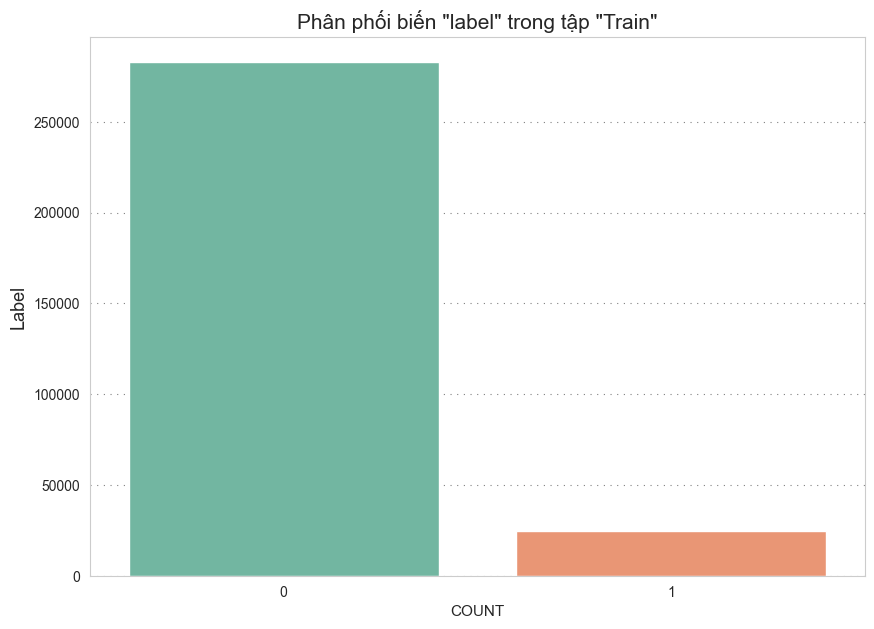

In [82]:
print(f'TARGET Count Value:\n{train_data.label.value_counts()}')

plt.figure(figsize=(10,7))

sns.countplot(data= train_data, x = 'label')
plt.grid(color='gray', linestyle=':', axis = 'y', zorder = 0,  dashes = (1,5))
plt.title('Phân phối biến "label" trong tập "Train"', fontsize= 15)
plt.xlabel("COUNT", fontsize= 11)
plt.ylabel("Label", fontsize= 13)

plt.show()

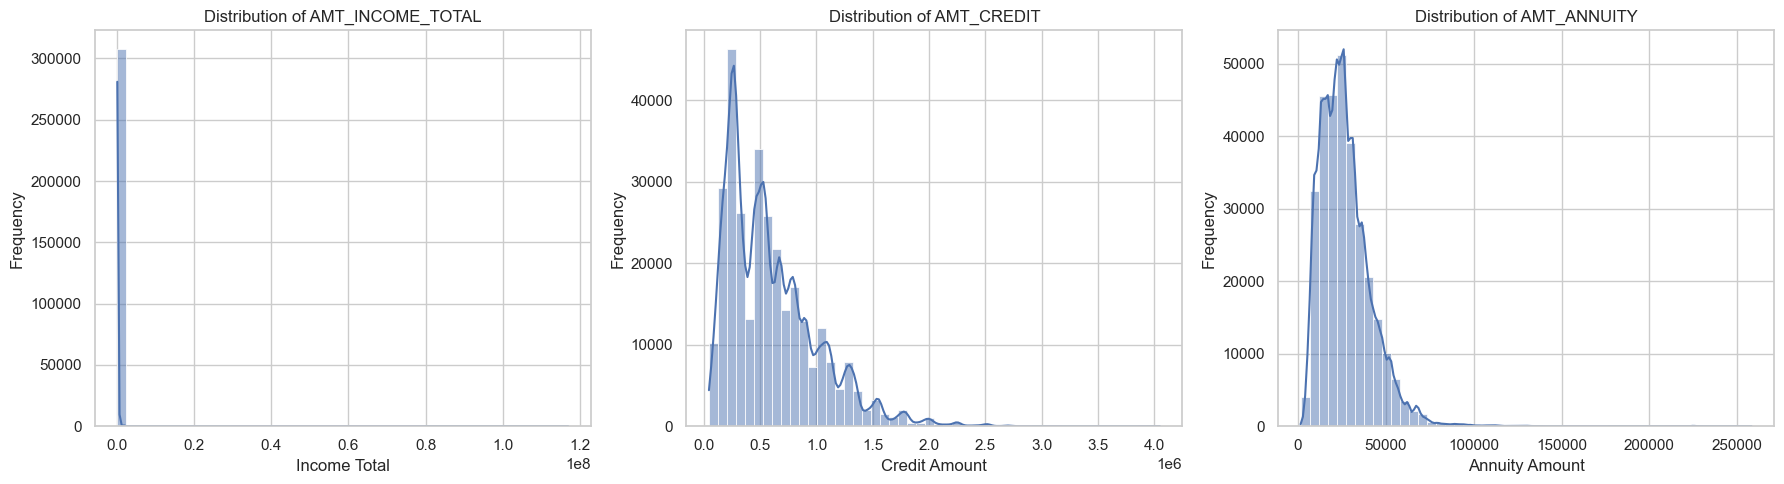

In [83]:
sns.set(style="whitegrid")

# Plotting distributions of some key numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution of AMT_INCOME_TOTAL
sns.histplot(train_data['AMT_INCOME_TOTAL'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Distribution of AMT_INCOME_TOTAL')
axes[0].set_xlabel('Income Total')
axes[0].set_ylabel('Frequency')

# Distribution of AMT_CREDIT
sns.histplot(train_data['AMT_CREDIT'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Distribution of AMT_CREDIT')
axes[1].set_xlabel('Credit Amount')
axes[1].set_ylabel('Frequency')

# Distribution of AMT_ANNUITY
sns.histplot(train_data['AMT_ANNUITY'], bins=50, ax=axes[2], kde=True)
axes[2].set_title('Distribution of AMT_ANNUITY')
axes[2].set_xlabel('Annuity Amount')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Xử lý Missing Data**

> Thực hiện xác định % bị dữ liệu bị thiếu của các.

> Tiến hành xóa các trường dữ liệu lớn hơn 50%

In [84]:
# Kiểm tra Feature có bị Missing
def _check_missing_(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count() * 100).sort_values(ascending=False)

    # Lọc những cột có dữ liệu thiếu
    non_zero_total = total[total > 0]
    non_zero_percent = percent[percent > 0]

    # Nếu có ít nhất một cột có dữ liệu thiếu, trả về DataFrame
    if not non_zero_total.empty:
        return pd.concat([non_zero_total, non_zero_percent], axis=1, keys=['Total', 'Percent'])
    else:
        return pd.DataFrame(columns=['Total', 'Percent'])

In [85]:
_check_missing_(train_data)

Total    Percent
COMMONAREA_MODE           214865  69.872297
COMMONAREA_MEDI           214865  69.872297
COMMONAREA_AVG            214865  69.872297
NONLIVINGAPARTMENTS_MEDI  213514  69.432963
NONLIVINGAPARTMENTS_AVG   213514  69.432963
...                          ...        ...
EXT_SOURCE_2                 660   0.214626
AMT_GOODS_PRICE              278   0.090403
AMT_ANNUITY                   12   0.003902
CNT_FAM_MEMBERS                2   0.000650
DAYS_LAST_PHONE_CHANGE         1   0.000325

[67 rows x 2 columns]

In [86]:
# Xóa các trường dữ liệu lớn hơn 50%
def separate_columns_by_missing_percentage(data, threshold=50):
    columns_to_drop = []  # Danh sách cột có tỷ lệ thiếu dữ liệu lớn hơn 50%

    for dtype in ['object', 'int64', 'float64']:
        data_column = data.select_dtypes(include=[dtype])

        # Kiểm tra xem có dữ liệu bị thiếu không
        if data_column.isnull().sum().sum() == 0:
            print(f"Không có dữ liệu bị thiếu cho kiểu dữ liệu: {dtype}")
            continue

        missing_object = _check_missing_(data_column)

        # Lọc cột có tỷ lệ thiếu dữ liệu lớn hơn 50%
        to_drop_50 = missing_object[missing_object['Percent'] > threshold].index
        columns_to_drop.extend(to_drop_50)

    print("Features bị Missing > 50%:", len(columns_to_drop))

    return columns_to_drop

In [87]:
columns_to_drop = separate_columns_by_missing_percentage(train_data)

Không có dữ liệu bị thiếu cho kiểu dữ liệu: int64
Features bị Missing > 50%: 41


In [88]:
drop_column(train_data, columns_to_drop)
train_data.head()

label NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      1         Cash loans            N               Y             0   
1      0         Cash loans            N               N             0   
2      0    Revolving loans            Y               Y             0   
3      0         Cash loans            N               Y             0   
4      0         Cash loans            N               Y             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
0          202500.0    406597.5      24700.5         351000.0   Unaccompanied   
1          270000.0   1293502.5      35698.5        1129500.0          Family   
2           67500.0    135000.0       6750.0         135000.0   Unaccompanied   
3          135000.0    312682.5      29686.5         297000.0   Unaccompanied   
4          121500.0    513000.0      21865.5         513000.0   Unaccompanied   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 79 columns]

In [89]:
train_data.dtypes.value_counts()

int64      40
float64    27
object     12
dtype: int64

## Weight of Evidence - Information Value

In [90]:
from pandas.api.types import is_numeric_dtype

from Features import *
from AttributeRelevance import *

In [91]:
iv = IV()

def print_Information_value(feat_name):
    print("______________________________________________")
    print('%s is a %s predictor.' % (feat_name.feature.capitalize(), iv.interpret_iv(feat_name)))
    print('A feature with IV = 0.2 is a %s predictor.' % iv.interpretation(0.2))
    print()
    iv.print_iv(feat_name)

In [92]:
feats_dict = {}

for col in [c for c in train_data.columns if c != 'label']:
    if is_numeric_dtype(train_data[col]):
        feats_dict[col] = ContinuousFeature(train_data, col)
    else:
        feats_dict[col] = CategoricalFeature(train_data, col)

feats = list(feats_dict.values())

In [93]:
feat_DAYS_EMPLOYED = ContinuousFeature(train_data, "DAYS_EMPLOYED")
#iv.group_by_feature(feat_DAYS_EMPLOYED)

iv_df, iv_value = iv.calculate_iv(feat_DAYS_EMPLOYED)
display(iv_df)
print('Information value: ', iv_value)
print_Information_value(feat_DAYS_EMPLOYED)

DAYS_EMPLOYED  count  good    bad  perc_good  perc_bad  perc_diff  \
0      -17912.001  23656  1062  22594   0.042779  0.079926  -0.037147   
1       -5455.000  23668  1348  22320   0.054300  0.078957  -0.024657   
2       -3823.000  23651  1563  22088   0.062961  0.078136  -0.015175   
3       -2933.000  23649  1740  21909   0.070091  0.077503  -0.007412   
4       -2306.000  23660  1904  21756   0.076697  0.076962  -0.000265   
5       -1781.000  23666  2213  21453   0.089144  0.075890   0.013254   
6       -1391.000  23693  2387  21306   0.096153  0.075370   0.020783   
7       -1058.000  23691  2578  21113   0.103847  0.074687   0.029160   
8        -765.000  23574  2647  20927   0.106626  0.074029   0.032597   
9        -484.000  23715  2724  20991   0.109728  0.074256   0.035473   
10       -230.000  70888  4659  66229   0.187674  0.234285  -0.046611   

         woe            iv  
0  -0.625045  2.321834e-02  
1  -0.374376  9.230890e-03  
2  -0.215942  3.277013e-03  
3  -0.100527  7.451372e-04  
4  -0.003447  9.129306e-07  
5   0.160970  2.133522e-03  
6   0.243534  5.061426e-03  
7   0.329610  9.611382e-03  
8   0.364872  1.189383e-02  
9   0.390493  1.385179e-02  
10 -0.221832  1.033981e-02

Information value:  0.0893640598374349
______________________________________________
Days_employed is a weak predictor.
A feature with IV = 0.2 is a medium predictor.

Information value: 0.09
Days_employed is a weak predictor


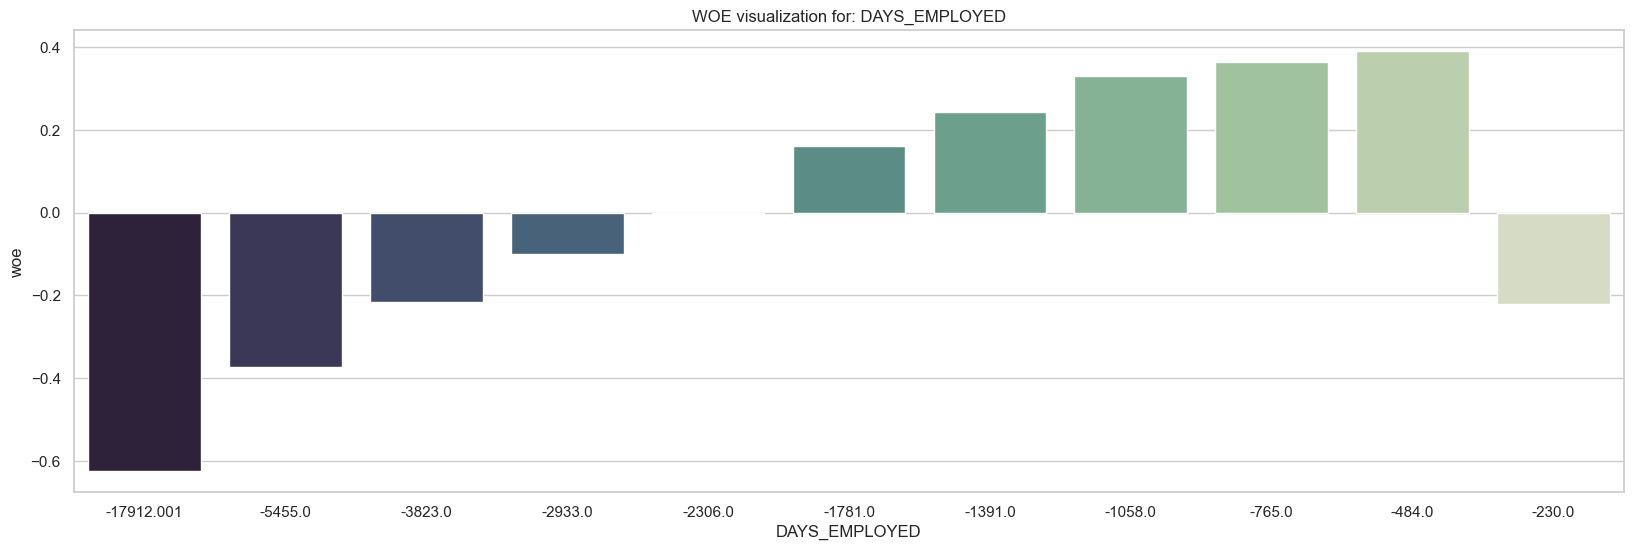

In [94]:
iv.draw_woe(feat_DAYS_EMPLOYED)

In [95]:
feat_FLAG_OWN_REALTY = CategoricalFeature(train_data, "FLAG_OWN_REALTY")
#iv.group_by_feature(feat_FLAG_OWN_REALTY)

iv_df, iv_value = iv.calculate_iv(feat_FLAG_OWN_REALTY)
display(iv_df)
print('Information value: ', iv_value)

print_Information_value(feat_FLAG_OWN_REALTY)

FLAG_OWN_REALTY   count   good     bad  perc_good  perc_bad  perc_diff  \
0               N   94199   7842   86357   0.315891  0.305487   0.010404   
1               Y  213312  16983  196329   0.684109  0.694513  -0.010404   

        woe        iv  
0  0.033490  0.000348  
1 -0.015093  0.000157

Information value:  0.000505451786583975
______________________________________________
Flag_own_realty is a useless predictor.
A feature with IV = 0.2 is a medium predictor.

Information value: 0.00
Flag_own_realty is a useless predictor


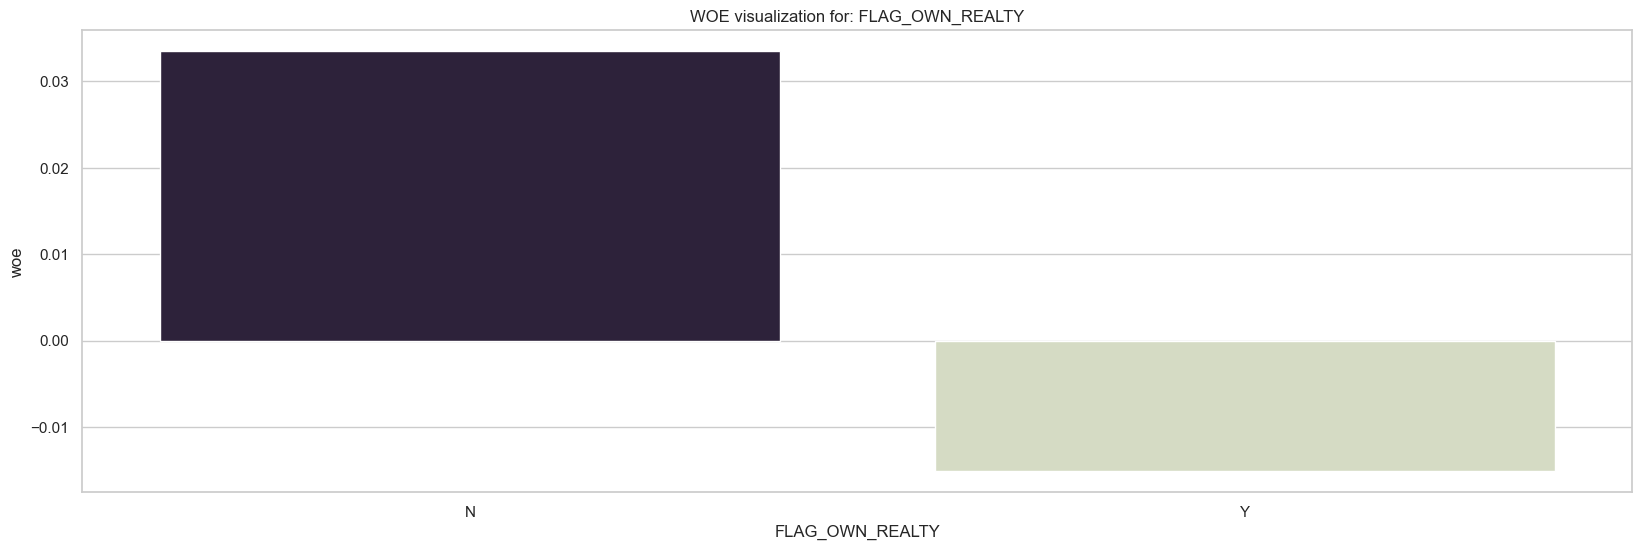

In [96]:
iv.draw_woe(feat_FLAG_OWN_REALTY)

## Variable Selection with Information Value (IV)

> Xác Định Ngưỡng IV để Lựa Chọn Biến, sẽ tiến hành loại bỏ các biến có Information value < 0.02 (useless for prediction)

| Information value        | Predictive power           |
| ------------- |:-------------:|
| < 0.02      | useless for prediction |
| 0.02 - 0.1      | weak predictor      |
| 0.1 - 0.3 | medium predictor      |
| 0.3 - 0.5 | strong predictor      |
| > 0.5 | suspicious or too good      |

In [97]:
# Hàm lấy ra các Feature tương ứng với IV_Interpretation
def Select_IV_feature(Information_Value, iv_interpretation):
    _features = Information_Value[Information_Value['iv_interpretation'] == iv_interpretation]['iv'].index.tolist()
    return _features

In [98]:
ar = AttributeRelevance()
Information_Value = ar.analyze(feats, iv, interpretation=True)
Information_Value.head()

iv iv_interpretation
EXT_SOURCE_3     0.333855            strong
EXT_SOURCE_2     0.317906            strong
DAYS_EMPLOYED    0.089364              weak
DAYS_BIRTH       0.084920              weak
OCCUPATION_TYPE  0.082865              weak

In [99]:
useless_features = Select_IV_feature(Information_Value, 'useless')
print(f"Useless Features: {len(useless_features)}")

weak_features = Select_IV_feature(Information_Value, 'weak')
print(f"Weak Features:    {len(weak_features)} : {weak_features}")

medium_features = Select_IV_feature(Information_Value, 'medium')
print(f"Medium Features:  {len(medium_features)}")

strong_features = Select_IV_feature(Information_Value, 'strong')
print(f"Strong Features:  {len(strong_features)} : {strong_features}")

Useless Features: 55
Weak Features:    21 : ['DAYS_EMPLOYED', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE', 'TOTALAREA_MODE', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'EMERGENCYSTATE_MODE', 'DAYS_REGISTRATION', 'NAME_FAMILY_STATUS']
Medium Features:  0
Strong Features:  2 : ['EXT_SOURCE_3', 'EXT_SOURCE_2']


> **Tiến hành loại bỏ các Feature - Useless**

In [100]:
filtered_df = Information_Value[Information_Value['iv_interpretation'] != 'useless']
filtered_df = filtered_df.reset_index().rename(columns={'index': 'Feature'})

#Lấy tên các Feature còn lại.
selected_features = filtered_df['Feature'].tolist()
filtered_df.head()

Feature        iv iv_interpretation
0     EXT_SOURCE_3  0.333855            strong
1     EXT_SOURCE_2  0.317906            strong
2    DAYS_EMPLOYED  0.089364              weak
3       DAYS_BIRTH  0.084920              weak
4  OCCUPATION_TYPE  0.082865              weak

> **Phân tích Tương Quan**

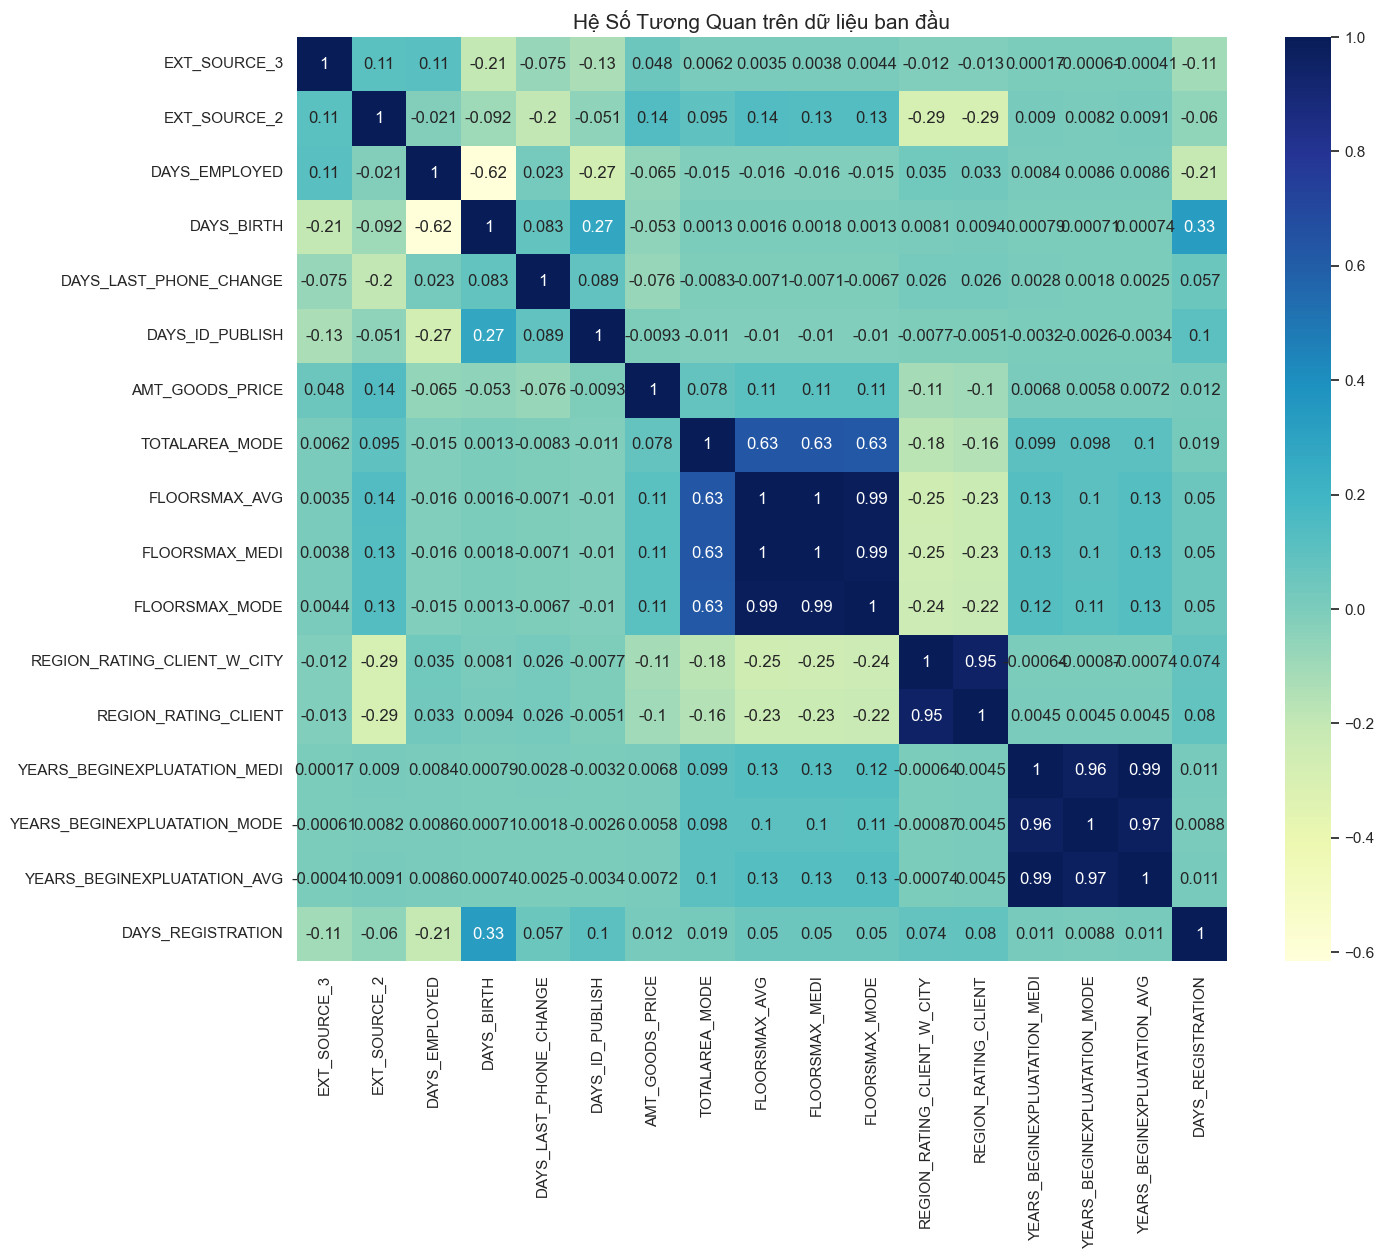

In [101]:
corrmat = train_data[selected_features].corr()
#print(f"Hệ số tương quan: \n{corrmat.sort_values(by = ['label'], ascending=False).iloc[0].sort_values(ascending=False)}")

plt.figure(figsize = (15,12))
sns.heatmap(corrmat,  cmap="YlGnBu", annot = True)
plt.title('Hệ Số Tương Quan trên dữ liệu ban đầu', fontsize = 15)
plt.show()

> **Lựa chọn và giữ lại Feature có IV cao hơn**

In [102]:
HTQ1 = ['FLOORSMAX_AVG', 'FLOORSMAX_MEDI','FLOORSMAX_MODE']
HTQ2 = ['YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG']
HTQ3 = ['REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']
HTQ = [HTQ1, HTQ2, HTQ3]

for i in HTQ:
    filtered_info = filtered_df[filtered_df['Feature'].isin(i)]
    print(filtered_info)

           Feature        iv iv_interpretation
12   FLOORSMAX_AVG  0.034740              weak
13  FLOORSMAX_MEDI  0.034703              weak
14  FLOORSMAX_MODE  0.034070              weak
                         Feature        iv iv_interpretation
17  YEARS_BEGINEXPLUATATION_MEDI  0.027444              weak
18  YEARS_BEGINEXPLUATATION_MODE  0.027350              weak
19   YEARS_BEGINEXPLUATATION_AVG  0.027336              weak
                        Feature        iv iv_interpretation
15  REGION_RATING_CLIENT_W_CITY  0.029387              weak
16         REGION_RATING_CLIENT  0.027649              weak


In [103]:
values_to_drop = ['FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'REGION_RATING_CLIENT']
filtered_df = filtered_df[~filtered_df['Feature'].isin(values_to_drop)]
selected_features = filtered_df['Feature'].tolist()
selected_features.append('label')
print(selected_features)
filtered_df.head()

['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE', 'TOTALAREA_MODE', 'FLOORSMAX_AVG', 'REGION_RATING_CLIENT_W_CITY', 'YEARS_BEGINEXPLUATATION_MEDI', 'EMERGENCYSTATE_MODE', 'DAYS_REGISTRATION', 'NAME_FAMILY_STATUS', 'label']


Feature        iv iv_interpretation
0     EXT_SOURCE_3  0.333855            strong
1     EXT_SOURCE_2  0.317906            strong
2    DAYS_EMPLOYED  0.089364              weak
3       DAYS_BIRTH  0.084920              weak
4  OCCUPATION_TYPE  0.082865              weak

In [104]:
filtered_df

Feature        iv iv_interpretation
0                   EXT_SOURCE_3  0.333855            strong
1                   EXT_SOURCE_2  0.317906            strong
2                  DAYS_EMPLOYED  0.089364              weak
3                     DAYS_BIRTH  0.084920              weak
4                OCCUPATION_TYPE  0.082865              weak
5              ORGANIZATION_TYPE  0.073368              weak
6               NAME_INCOME_TYPE  0.059625              weak
7            NAME_EDUCATION_TYPE  0.050836              weak
8         DAYS_LAST_PHONE_CHANGE  0.045631              weak
9                DAYS_ID_PUBLISH  0.038630              weak
10               AMT_GOODS_PRICE  0.036025              weak
11                TOTALAREA_MODE  0.035743              weak
12                 FLOORSMAX_AVG  0.034740              weak
15   REGION_RATING_CLIENT_W_CITY  0.029387              weak
17  YEARS_BEGINEXPLUATATION_MEDI  0.027444              weak
20           EMERGENCYSTATE_MODE  0.024044              weak
21             DAYS_REGISTRATION  0.022675              weak
22            NAME_FAMILY_STATUS  0.021777              weak

**Kết luận**

> Sau quá trình áp dụng phân tích WoE và IV, đã lựa chọn các biến bao gồm 2 biến Mạnh (Strong) và 16 biến Yếu (weak) để xây dựng mô hình bao gồm:

**1. Biến Mạnh (Strong):**

- `EXT_SOURCE_3:` Đây là biến có IV cao nhất và được xem là một biến mạnh.
- `EXT_SOURCE_2:`Cũng là một biến mạnh có IV cao.

**2. Biến Yếu (Weak):**

- `DAYS_EMPLOYED, DAYS_BIRTH,DAYS_REGISTRATION` ,...:  Đây là biến có IV thấp hơn so với các biến mạnh.

## Variable Transformation (WoE)

> Mô hình sẽ không hồi qui trực tiếp trên các biến gốc mà thay vào đó giá trị WOE ở từng biến sẽ được sử dụng thay thế để làm đầu vào

In [105]:
train_woe = train_data[selected_features]
train_woe.head(3)

EXT_SOURCE_3  EXT_SOURCE_2  DAYS_EMPLOYED  DAYS_BIRTH OCCUPATION_TYPE  \
0      0.139376      0.262949           -637       -9461        Laborers   
1           NaN      0.622246          -1188      -16765      Core staff   
2      0.729567      0.555912           -225      -19046        Laborers   

        ORGANIZATION_TYPE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0  Business Entity Type 3          Working  Secondary / secondary special   
1                  School    State servant               Higher education   
2              Government          Working  Secondary / secondary special   

   DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  AMT_GOODS_PRICE  TOTALAREA_MODE  \
0                 -1134.0            -2120         351000.0          0.0149   
1                  -828.0             -291        1129500.0          0.0714   
2                  -815.0            -2531         135000.0             NaN   

   FLOORSMAX_AVG  REGION_RATING_CLIENT_W_CITY  YEARS_BEGINEXPLUATATION_MEDI  \
0         0.0833                            2                        0.9722   
1         0.2917                            1                        0.9851   
2            NaN                            2                           NaN   

  EMERGENCYSTATE_MODE  DAYS_REGISTRATION    NAME_FAMILY_STATUS  label  
0                  No            -3648.0  Single / not married      1  
1                  No            -1186.0               Married      0  
2                 NaN            -4260.0  Single / not married      0

In [106]:
feats_dict_Continuous = {}
feats_dict_Categorical = {}

for col in [c for c in train_woe.columns if c != 'label']:
    if is_numeric_dtype(train_woe[col]):
        feats_dict_Continuous[col] = ContinuousFeature(train_woe, col)
    else:
        feats_dict_Categorical[col] = CategoricalFeature(train_woe, col)

feats_Continuous = feats_dict_Continuous.keys()
feats_Categorical = feats_dict_Categorical.keys()

In [107]:
feats_Continuous

dict_keys(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_GOODS_PRICE', 'TOTALAREA_MODE', 'FLOORSMAX_AVG', 'REGION_RATING_CLIENT_W_CITY', 'YEARS_BEGINEXPLUATATION_MEDI', 'DAYS_REGISTRATION'])

In [108]:
feats_Categorical

dict_keys(['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'EMERGENCYSTATE_MODE', 'NAME_FAMILY_STATUS'])

> **CategoricalFeature**

In [109]:
def Map_woe_values_CategoricalFeature(df, feature_column):
    '''
    'feature_column': là Feature chung của iv_df và df
    '''
    df[feature_column].fillna("MISSING", inplace=True)

    feat_ = CategoricalFeature(df, feature_column)
    iv_df, iv_value = iv.calculate_iv(feat_)
    woe_mapping = iv_df.set_index(feature_column)['woe'].to_dict() # Tạo ra dict chứa thông tin của feature_column
    df[feature_column] = df[feature_column].map(woe_mapping) # Chuyển đổi theo dict tương ứng
    return df

In [110]:
for index in feats_Categorical:
    Map_woe_values_CategoricalFeature(train_woe, index)
train_woe.drop(['bin'], axis = 1, inplace = True)

In [111]:
train_woe.head()

EXT_SOURCE_3  EXT_SOURCE_2  DAYS_EMPLOYED  DAYS_BIRTH  OCCUPATION_TYPE  \
0      0.139376      0.262949           -637       -9461         0.297977   
1           NaN      0.622246          -1188      -16765        -0.266393   
2      0.729567      0.555912           -225      -19046         0.297977   
3           NaN      0.650442          -3039      -19005         0.297977   
4           NaN      0.322738          -3038      -19932        -0.266393   

   ORGANIZATION_TYPE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0           0.154898          0.188675             0.111494   
1          -0.334264         -0.363350            -0.439594   
2          -0.157575          0.188675             0.111494   
3           0.154898          0.188675             0.111494   
4          -0.340103          0.188675             0.111494   

   DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  AMT_GOODS_PRICE  TOTALAREA_MODE  \
0                 -1134.0            -2120         351000.0          0.0149   
1                  -828.0             -291        1129500.0          0.0714   
2                  -815.0            -2531         135000.0             NaN   
3                  -617.0            -2437         297000.0             NaN   
4                 -1106.0            -3458         513000.0             NaN   

   FLOORSMAX_AVG  REGION_RATING_CLIENT_W_CITY  YEARS_BEGINEXPLUATATION_MEDI  \
0         0.0833                            2                        0.9722   
1         0.2917                            1                        0.9851   
2            NaN                            2                           NaN   
3            NaN                            2                           NaN   
4            NaN                            2                           NaN   

   EMERGENCYSTATE_MODE  DAYS_REGISTRATION  NAME_FAMILY_STATUS  label  
0            -0.159608            -3648.0            0.213706      1  
1            -0.159608            -1186.0           -0.071222      0  
2             0.150280            -4260.0            0.213706      0  
3             0.150280            -9833.0            0.229088      0  
4             0.150280            -4311.0            0.213706      0

> **ContinuousFeature**

In [112]:
def map_days_employed(value, mapping):
    for interval, new_value in mapping:
        if value in pd.Interval(*interval):
            return new_value

In [113]:
def Mapping_WoE_values_ContinuousFeature(data, feature_column):

    if data[feature_column].isnull().values.any():

        feat_ = ContinuousFeature(data, feature_column)
        iv_df, iv_value = iv.calculate_iv(feat_)
        woe_mapping = iv_df.set_index(feature_column)['woe'].to_dict()
        last_pair_woe_mapping = list(woe_mapping.items())[-1]

        # Sắp xếp các khóa số thực của dictionary theo thứ tự tăng dần
        sorted_keys = sorted([key for key in woe_mapping.keys() if isinstance(key, float)])

        # Tạo danh sách mới cho các phạm vi
        new_mapping = []
        for i in range(len(sorted_keys) - 1):
            # Lấy ra khoảng giữa khóa hiện tại và khóa tiếp theo
            new_mapping.append(((sorted_keys[i], sorted_keys[i + 1]), woe_mapping[sorted_keys[i]]))

        # Thêm khoảng cuối cùng
        #last_value = list(woe_mapping.values())[-1] if not missing_woe else missing_woe
        last_value = list(woe_mapping.values())[-2]
        new_mapping.append(((sorted_keys[-1], data[feature_column].describe().max()), last_value))
        new_mapping.append(last_pair_woe_mapping)

        __last_pair__ = list(new_mapping)[-1]
        new_mapping.remove(__last_pair__)

        data[feature_column] = data[feature_column].apply(lambda x: map_days_employed(x, new_mapping))

        data[feature_column].fillna('MISSING', inplace=True)
        data[feature_column] = data[feature_column].replace('MISSING', __last_pair__[1])

    else:
        feat_ = ContinuousFeature(data, feature_column)
        iv_df, iv_value = iv.calculate_iv(feat_)
        woe_mapping = iv_df.set_index(feature_column)['woe'].to_dict()

        # Sắp xếp các khóa của dictionary theo thứ tự tăng dần
        sorted_keys = sorted(woe_mapping.keys())
        # Tạo danh sách mới cho các phạm vi
        new_mapping = []
        for i in range(len(sorted_keys) - 1):
            # Lấy ra khoảng giữa khóa hiện tại và khóa tiếp theo
            new_mapping.append(((sorted_keys[i], sorted_keys[i + 1]), woe_mapping[sorted_keys[i]]))

        # Thêm khoảng cuối cùng
        last_value = list(woe_mapping.values())[-1]
        new_mapping.append(((sorted_keys[-1], data[feature_column].describe().max()), last_value))

        data[feature_column] = data[feature_column].apply(lambda x: map_days_employed(x, new_mapping))

    return data

In [114]:
for index in feats_Continuous:
    Mapping_WoE_values_ContinuousFeature(train_woe, index)

In [115]:
train_woe.head(5)

EXT_SOURCE_3  EXT_SOURCE_2  DAYS_EMPLOYED  DAYS_BIRTH  OCCUPATION_TYPE  \
0      1.137488      0.451250       0.364872    0.394603         0.297977   
1      0.156353     -0.359976       0.243534   -0.083403        -0.266393   
2     -0.907005     -0.105118      -0.221832   -0.185642         0.297977   
3      0.156353     -0.405395      -0.215942   -0.185642         0.297977   
4      0.156353      0.353044      -0.215942   -0.341265        -0.266393   

   ORGANIZATION_TYPE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0           0.154898          0.188675             0.111494   
1          -0.334264         -0.363350            -0.439594   
2          -0.157575          0.188675             0.111494   
3           0.154898          0.188675             0.111494   
4          -0.340103          0.188675             0.111494   

   DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  AMT_GOODS_PRICE  TOTALAREA_MODE  \
0               -0.062550         0.114547         0.170672        0.135628   
1                0.098891         0.263420        -0.211889       -0.150764   
2                0.098891         0.114547         0.170672        0.147084   
3                0.173509         0.114547         0.170672        0.147084   
4               -0.062550         0.003787        -0.211889        0.147084   

   FLOORSMAX_AVG  REGION_RATING_CLIENT_W_CITY  YEARS_BEGINEXPLUATATION_MEDI  \
0      -0.046969                     -0.07708                     -0.020789   
1      -0.301987                     -0.07708                     -0.185269   
2       0.141947                     -0.07708                      0.143617   
3       0.141947                     -0.07708                      0.143617   
4       0.141947                     -0.07708                      0.143617   

   EMERGENCYSTATE_MODE  DAYS_REGISTRATION  NAME_FAMILY_STATUS  label  
0            -0.159608           0.085867            0.213706      1  
1            -0.159608           0.133858           -0.071222      0  
2             0.150280           0.085867            0.213706      0  
3             0.150280          -0.267573            0.229088      0  
4             0.150280           0.085867            0.213706      0

## Variable Analysis

In [116]:
df_visualization = train_data[selected_features]
feats_dict = {}

for col in [c for c in df_visualization.columns if c != 'label']:
    if is_numeric_dtype(df_visualization[col]):
        feats_dict[col] = ContinuousFeature(df_visualization, col)
    else:
        feats_dict[col] = CategoricalFeature(df_visualization, col)

feats = list(feats_dict.values())

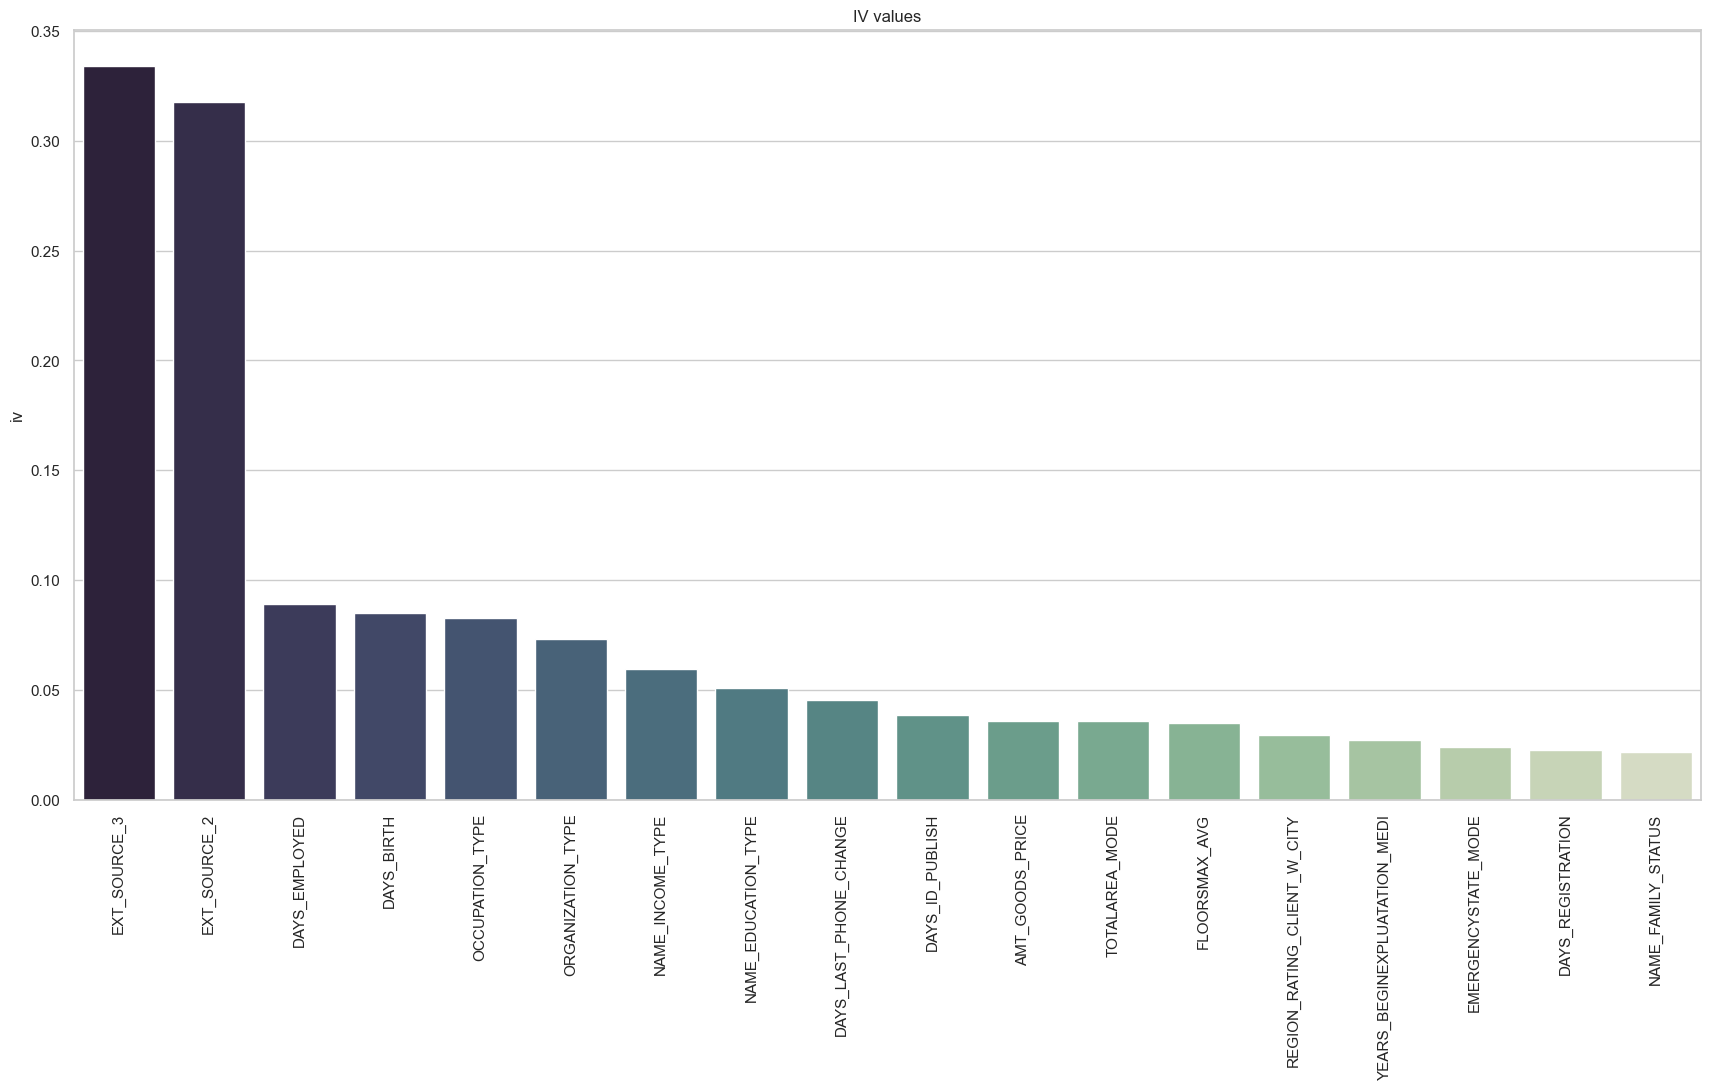

In [117]:
ar.draw_iv(feats, iv)

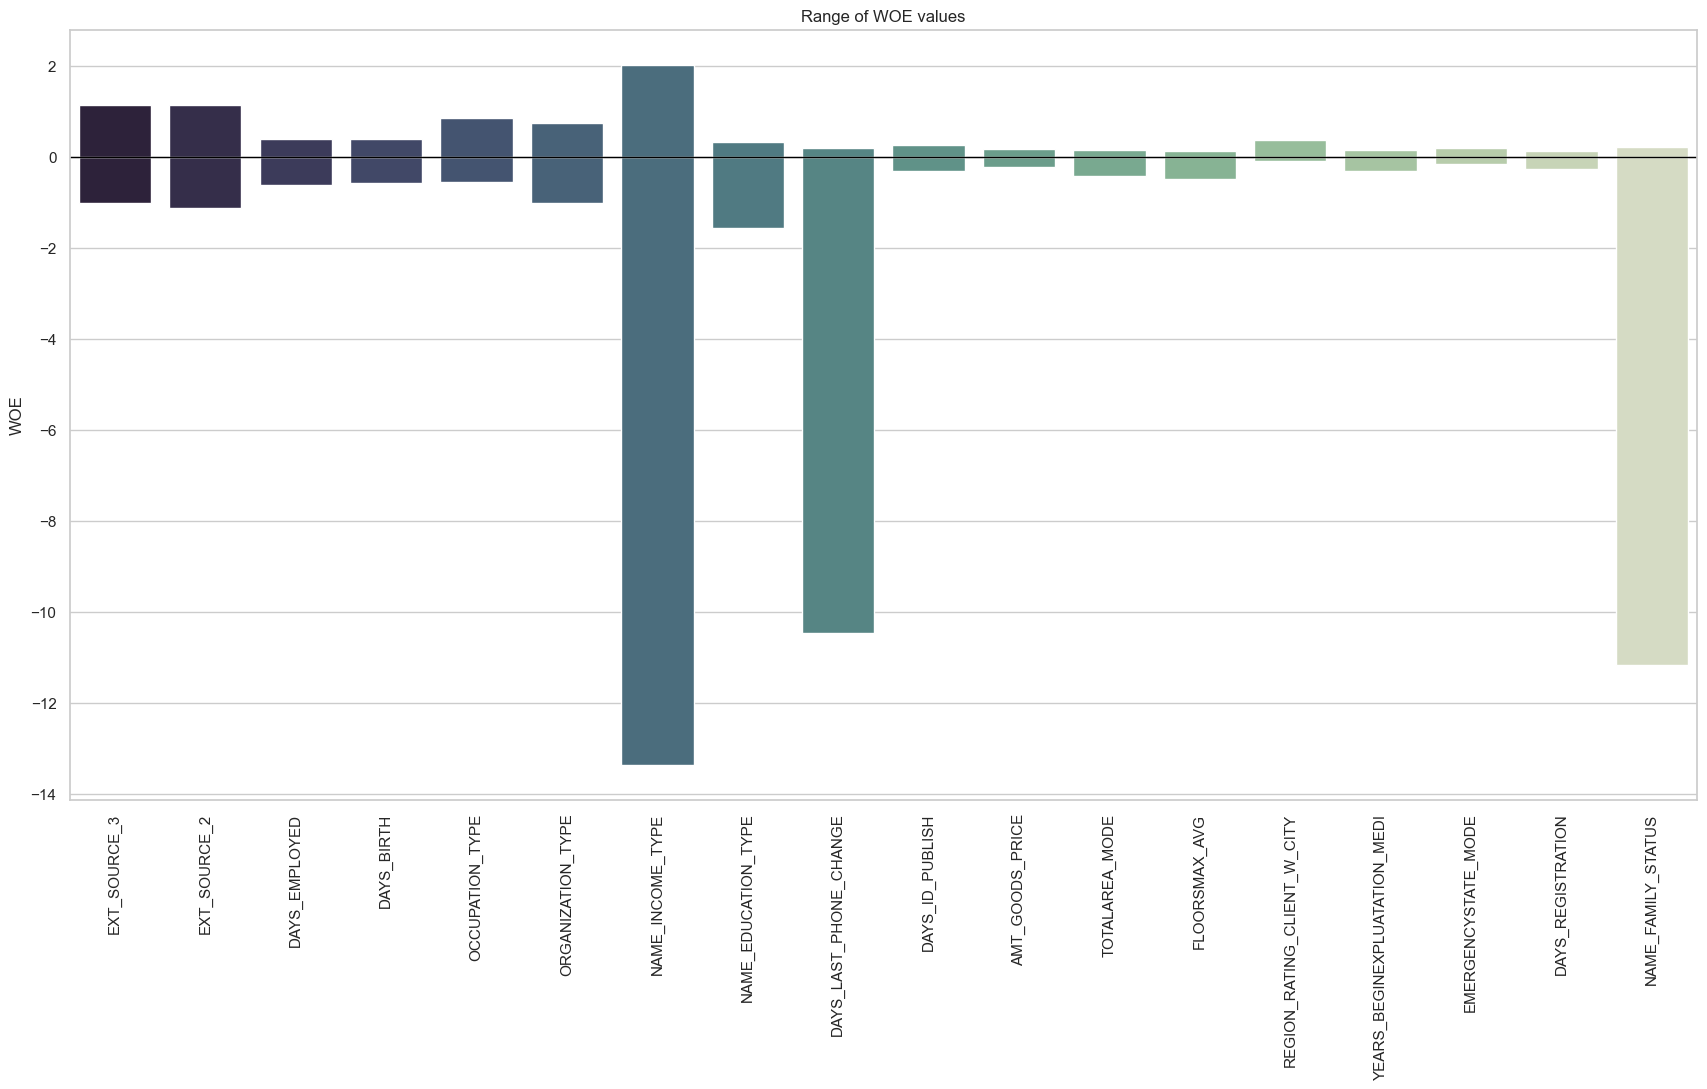

In [118]:
ar.draw_woe_extremes(feats, iv)

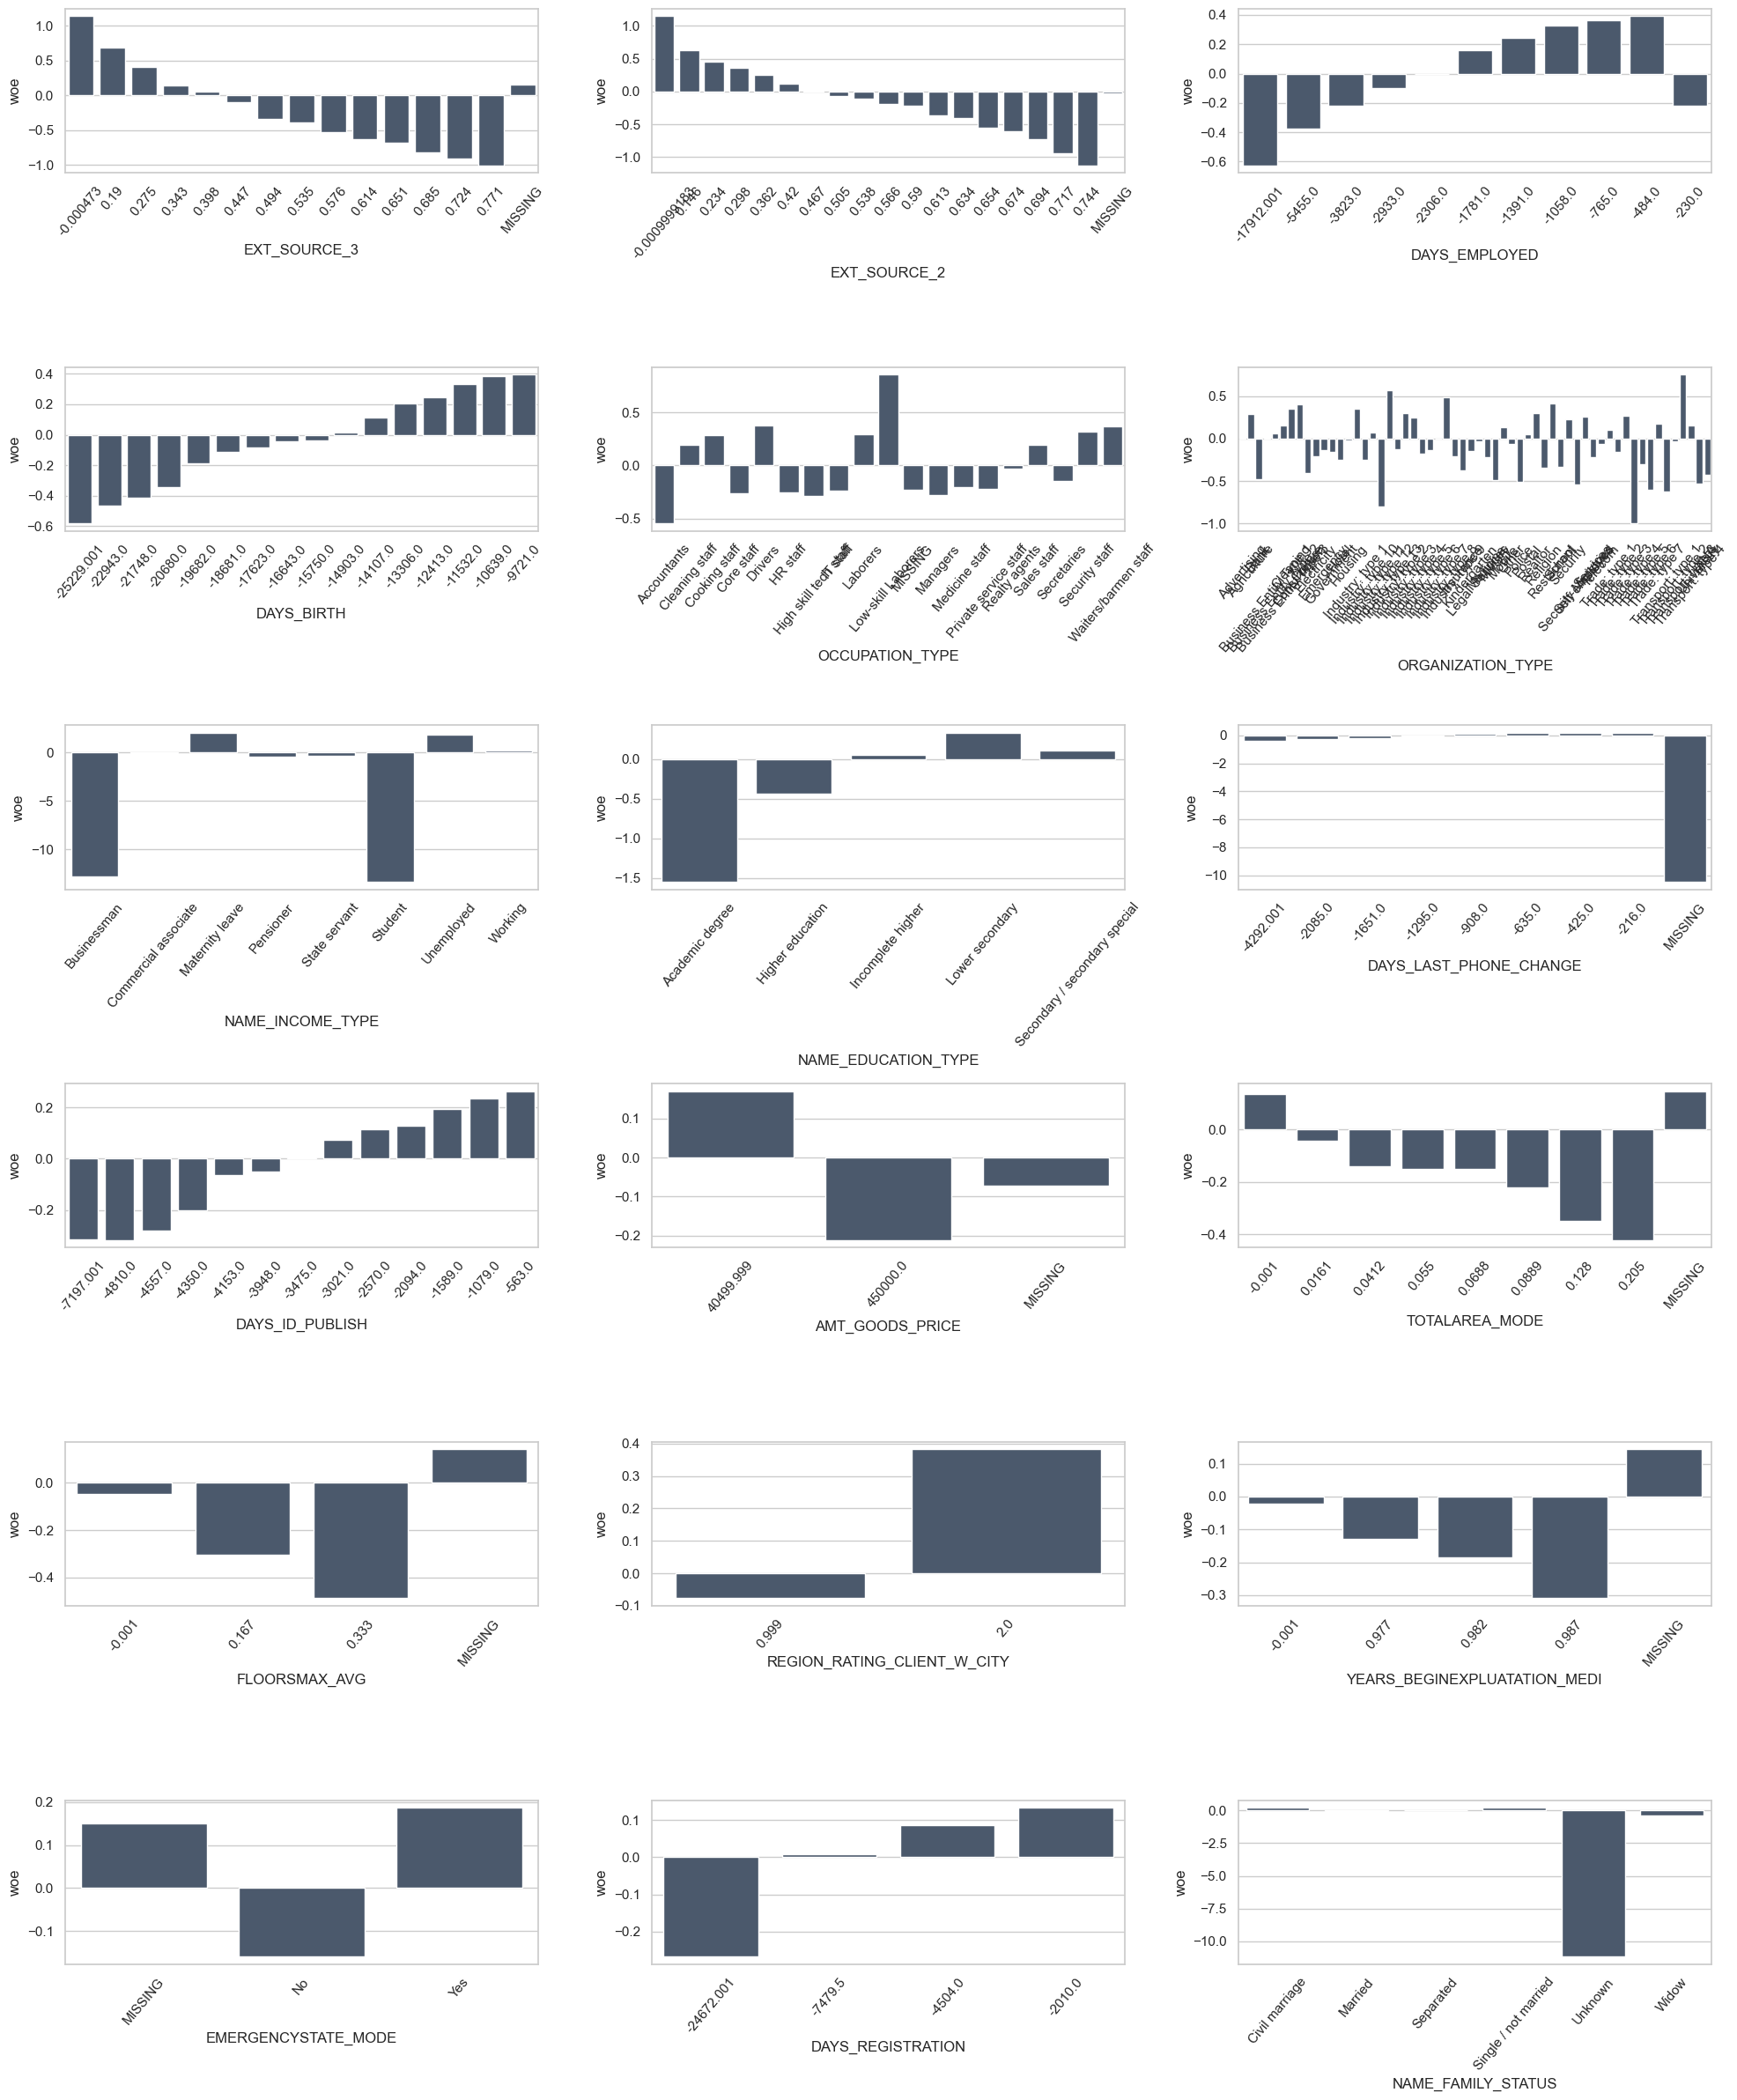

In [119]:
ar.draw_woe_multiplot(feats[:18], iv)

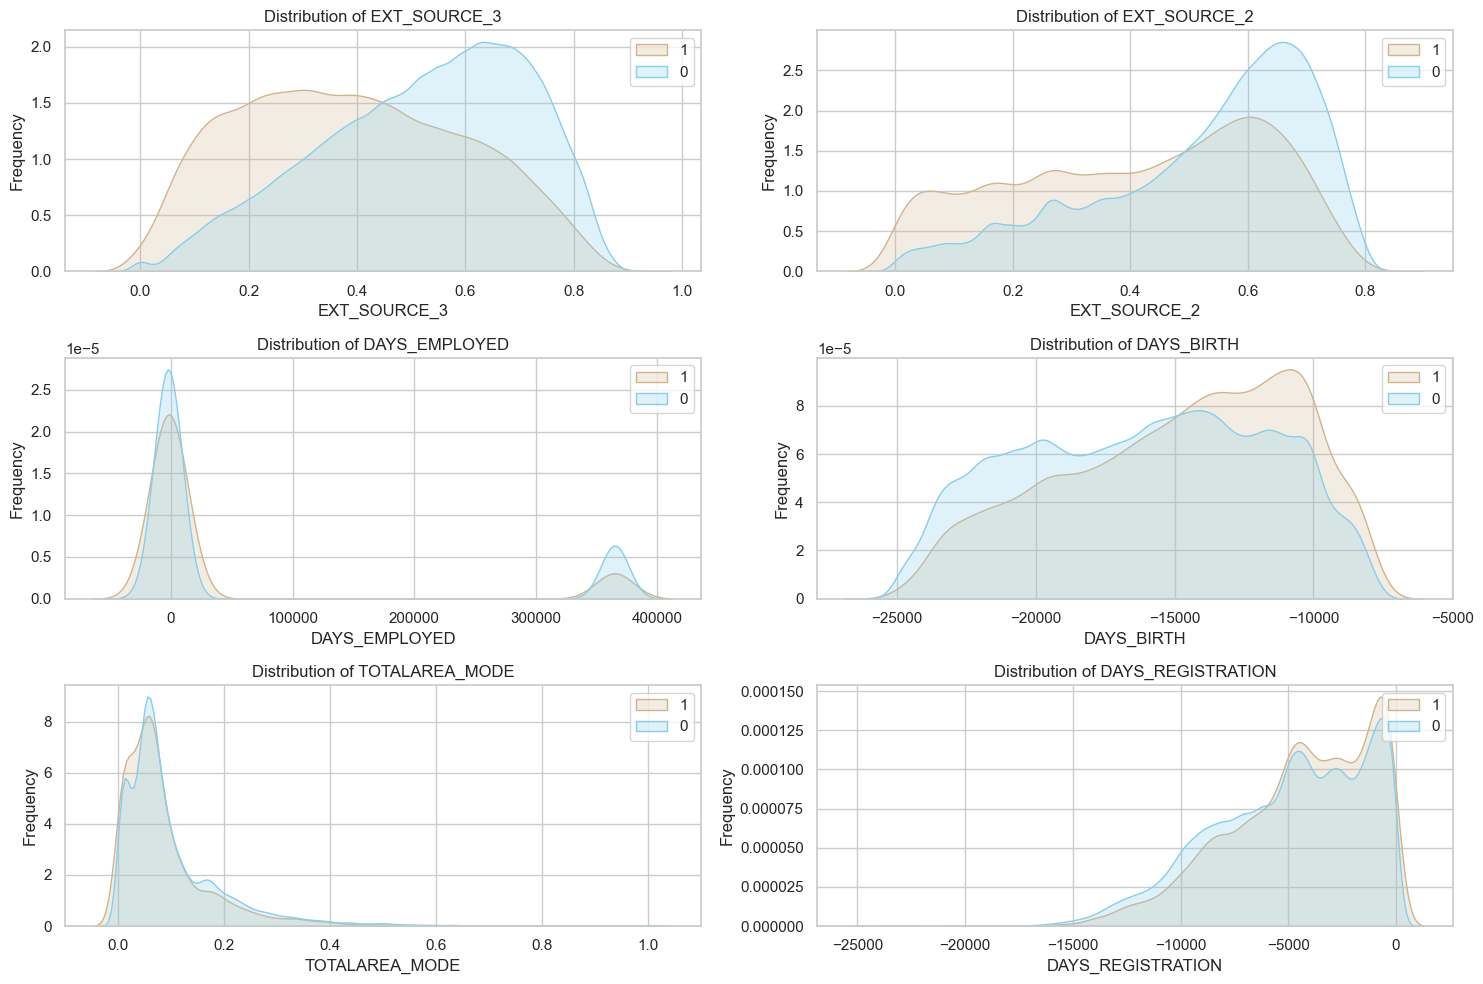

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Danh sách các biến số và biến phân loại
numeric_vars = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'TOTALAREA_MODE', 'DAYS_REGISTRATION']
categorical_vars = ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE']

# Thiết lập môi trường trực quan hóa
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Vẽ biểu đồ cho các biến số
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(train_data.loc[(train_data['label']== 1),var], color='tan', shade=True, label='1')
    sns.kdeplot(train_data.loc[(train_data['label']== 0),var], color='skyblue', shade=True, label='0')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.legend()
plt.show()

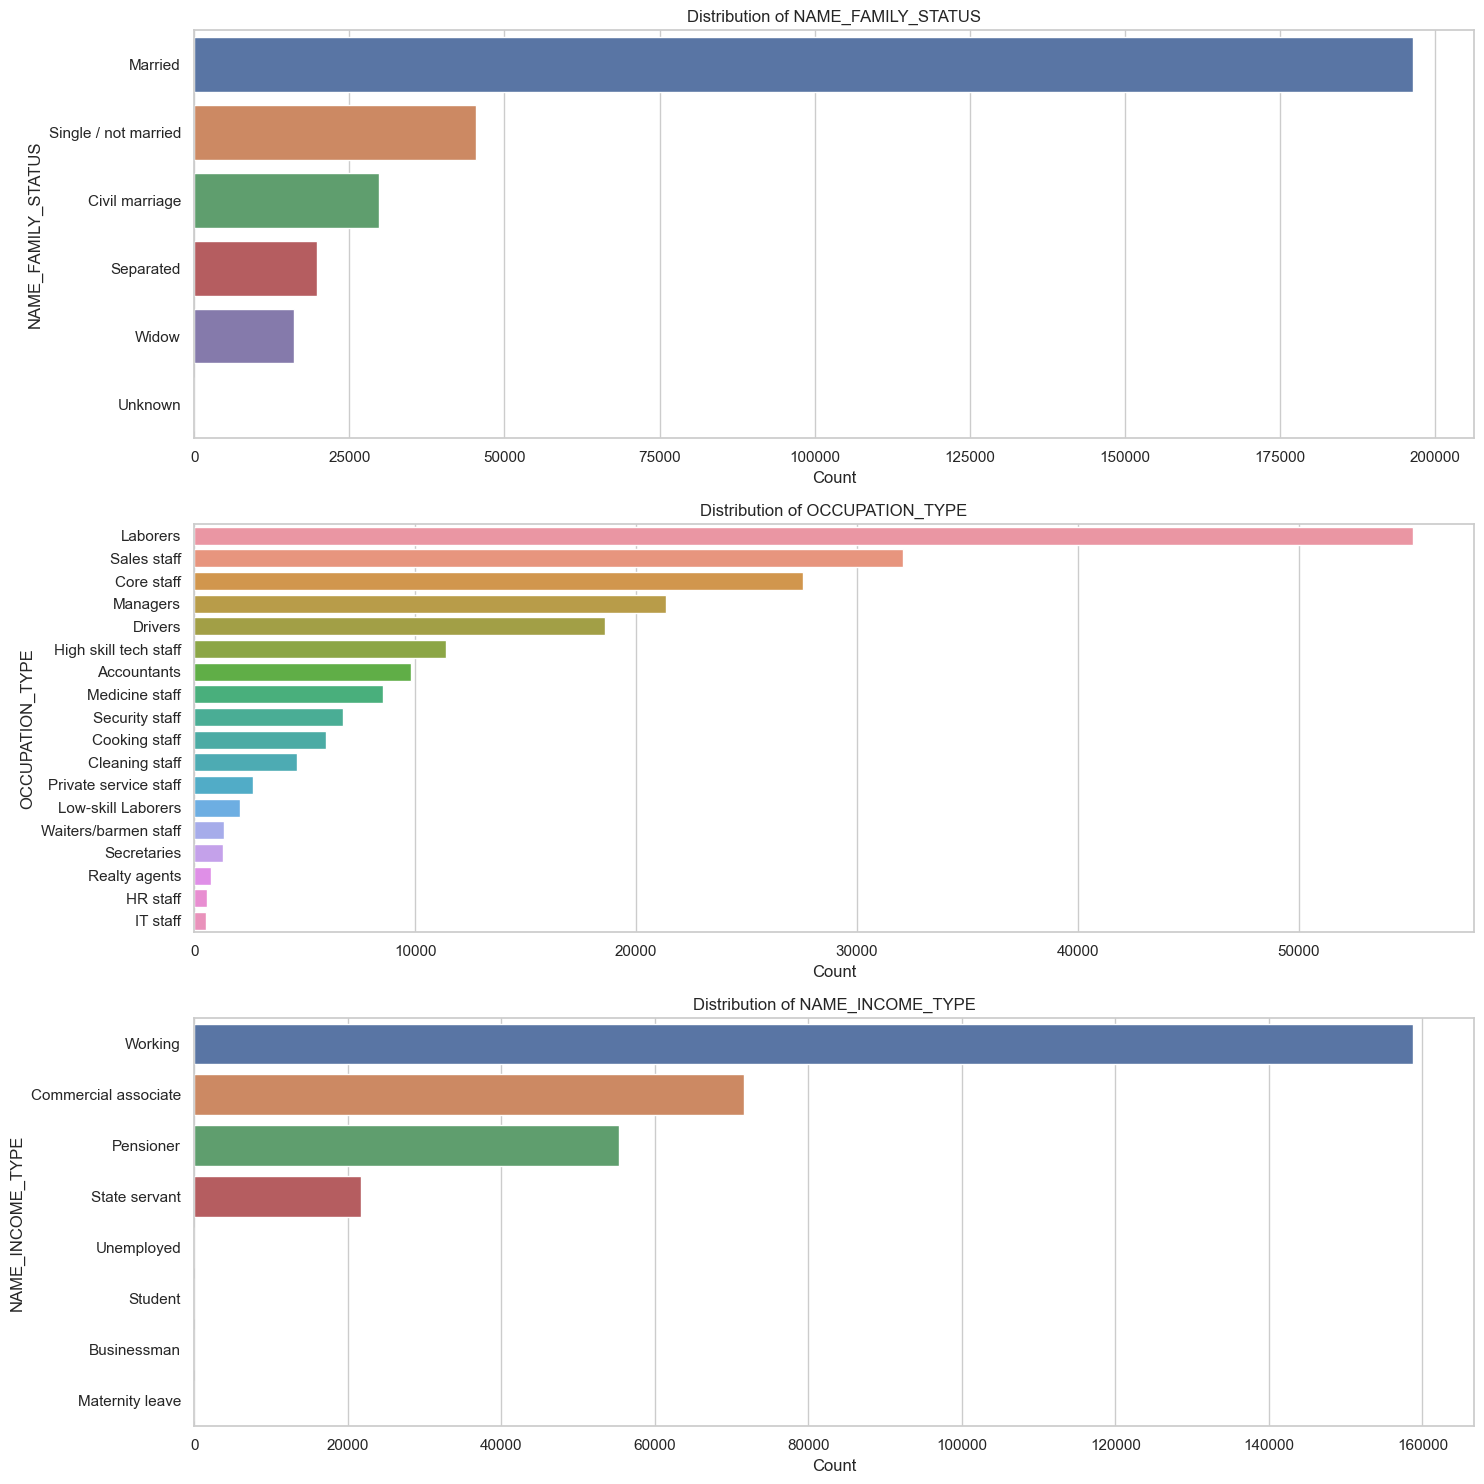

In [121]:
# Danh sách các biến phân loại
categorical_vars = ["NAME_FAMILY_STATUS", "OCCUPATION_TYPE", "NAME_INCOME_TYPE"]

# Thiết lập môi trường vẽ
plt.figure(figsize=(15, 15))

# Vẽ biểu đồ phân phối cho mỗi biến phân loại
for i, var in enumerate(categorical_vars):
    plt.subplot(3, 1, i+1)
    sns.countplot(y=train_data[var], order = train_data[var].value_counts().index)
    plt.title(f'Distribution of {var}')
    plt.xlabel('Count')
    plt.ylabel(var)

plt.tight_layout()
plt.show()


In [122]:
def WOE_Visualization(data, feature, iv_value):
    plt.style.use('default')
    fig, ax1 = plt.subplots(figsize=(20, 8))
    positions = np.arange(len(data))

    # Combined bars for 'good' and 'bad' counts
    bars = ax1.bar(positions, data['perc_good'], 0.4, label='Good', color='tan', edgecolor='grey')
    bars2 = ax1.bar(positions, data['perc_bad'], 0.4, bottom=data['perc_good'], label='Bad', color='aquamarine', edgecolor='grey')

    # Adding the count values on top of the combined bars
    for idx in positions:
        # Good count
        ax1.text(x=idx, y=data['perc_good'].iloc[idx] + data['perc_bad'].iloc[idx] + 0.01, s=f"{int(data['good'].iloc[idx])}", ha='center', va='bottom')
        # Bad count
        ax1.text(x=idx, y=data['perc_bad'].iloc[idx] + 0.01, s=f"{int(data['bad'].iloc[idx])}", ha='center', va='bottom')

    # Line for 'Weight of Evidence (WoE)'
    ax2 = ax1.twinx()
    line = ax2.plot(positions, data['woe'], label='WoE', color='green', marker='o')

    # Formatting the plot
    ax1.set_xticks(positions)
    ax1.set_xticklabels(data[feature], rotation=45)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Percentage of Good/Bad')
    ax2.set_ylabel('Weight of Evidence (WoE)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show plot
    plt.suptitle(feature)
    plt.title(f"Information Value: {round(iv_value, 4)}", fontweight='bold')
    plt.tight_layout()
    plt.show()

> **EXT_SOURCE_3**

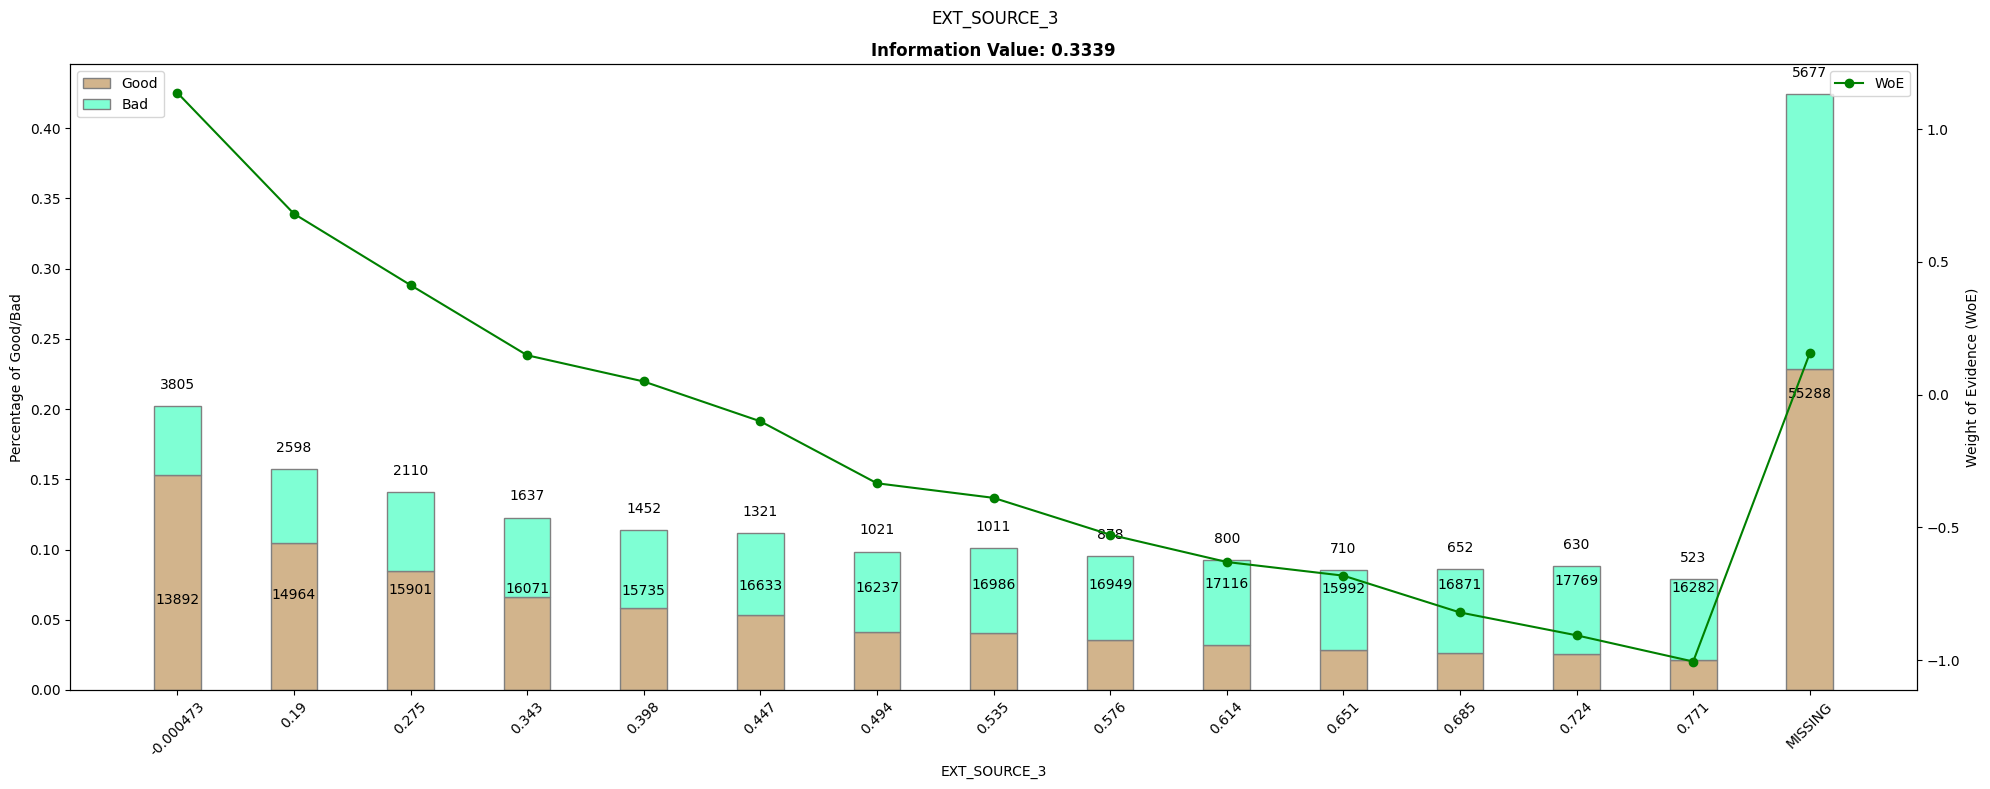

In [123]:
feat_value = ContinuousFeature(df_visualization, "EXT_SOURCE_3")
iv_df_1, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_1, 'EXT_SOURCE_3', iv_value)

> **EXT_SOURCE_2**

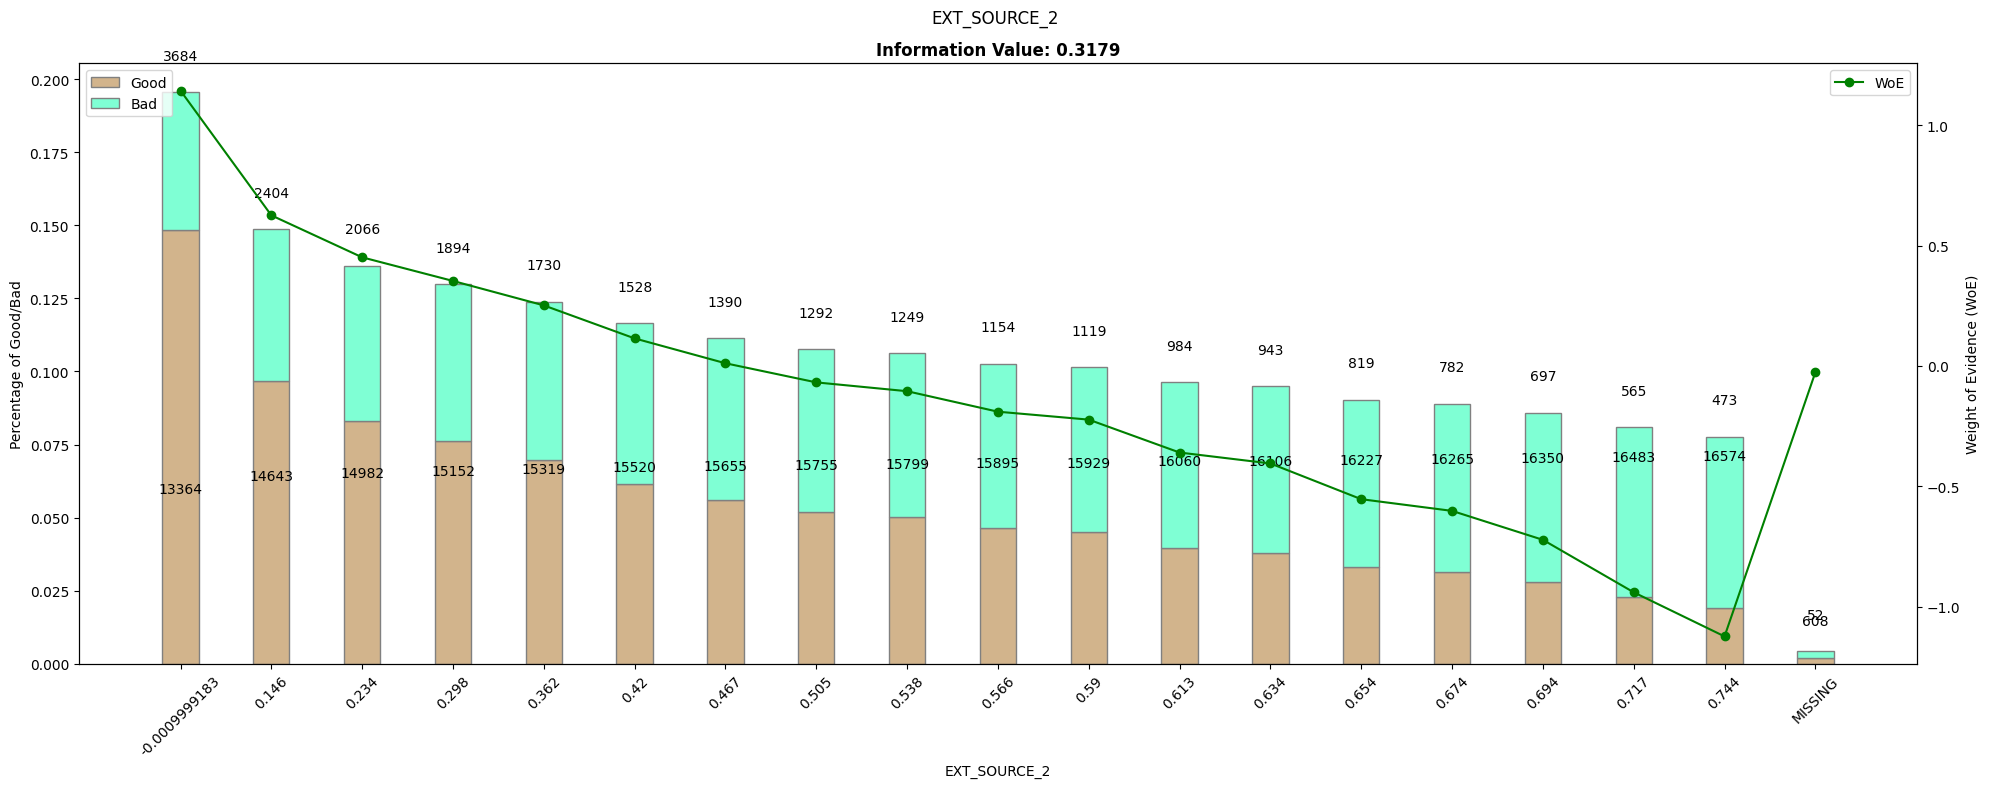

In [124]:
feat_value = ContinuousFeature(df_visualization, "EXT_SOURCE_2")
iv_df_2, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_2, 'EXT_SOURCE_2', iv_value)

> **DAYS_EMPLOYED**

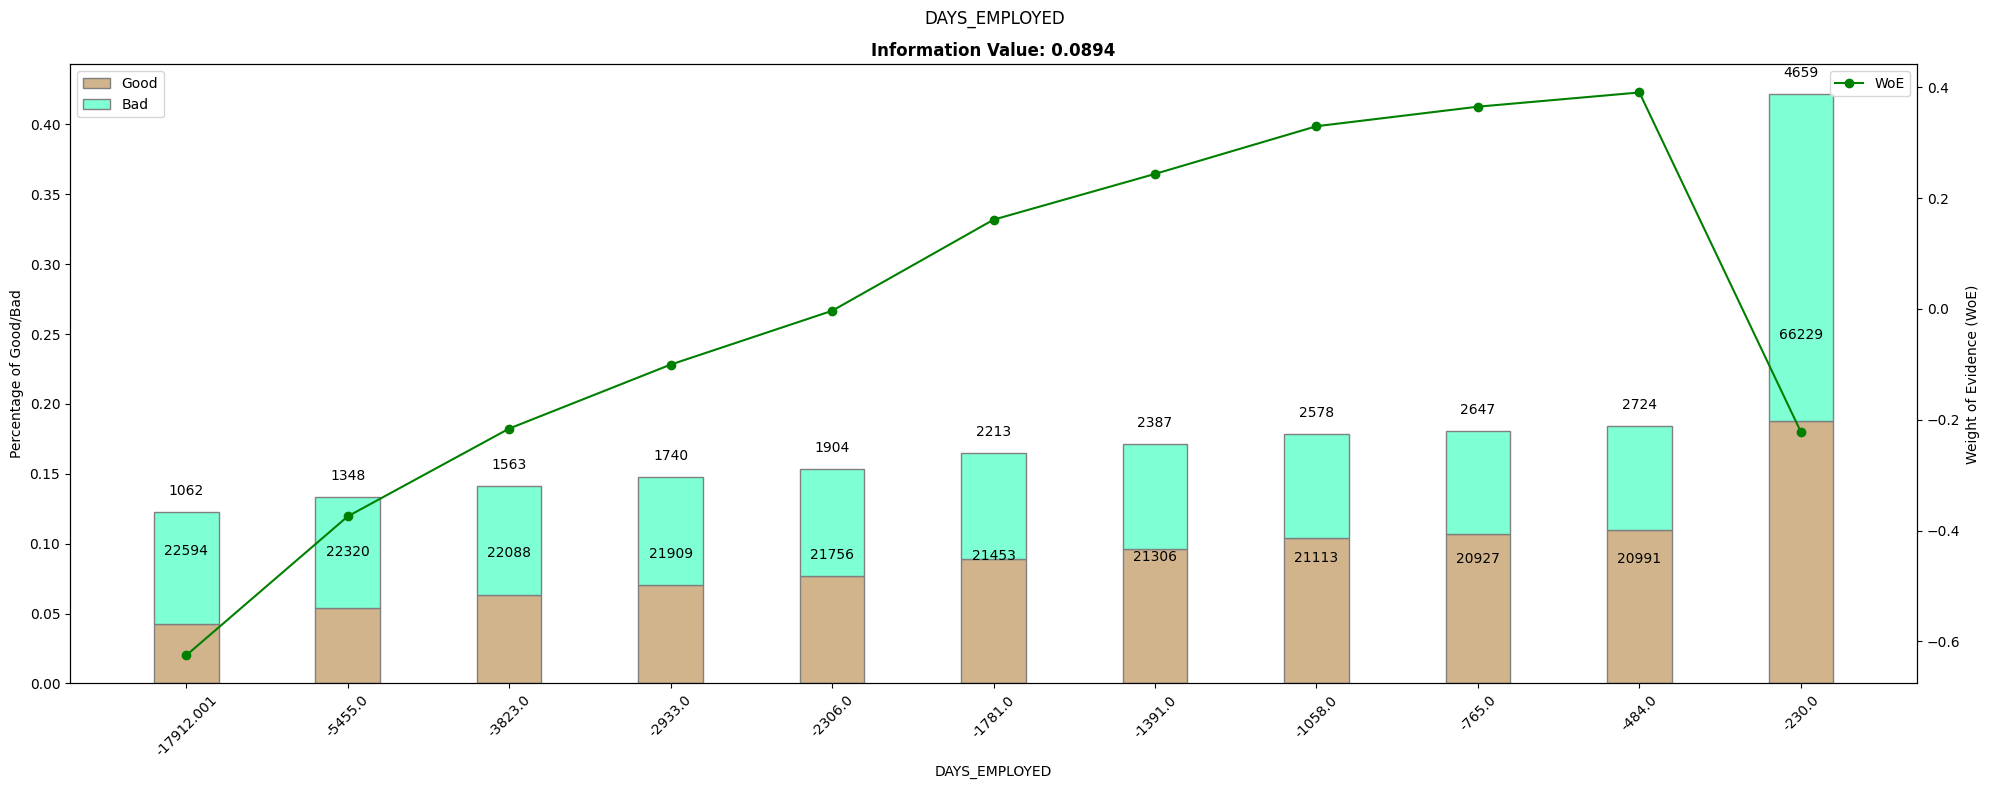

In [125]:
feat_value = ContinuousFeature(df_visualization, "DAYS_EMPLOYED")
iv_df_3, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_3, 'DAYS_EMPLOYED', iv_value)

> **DAYS_BIRTH**

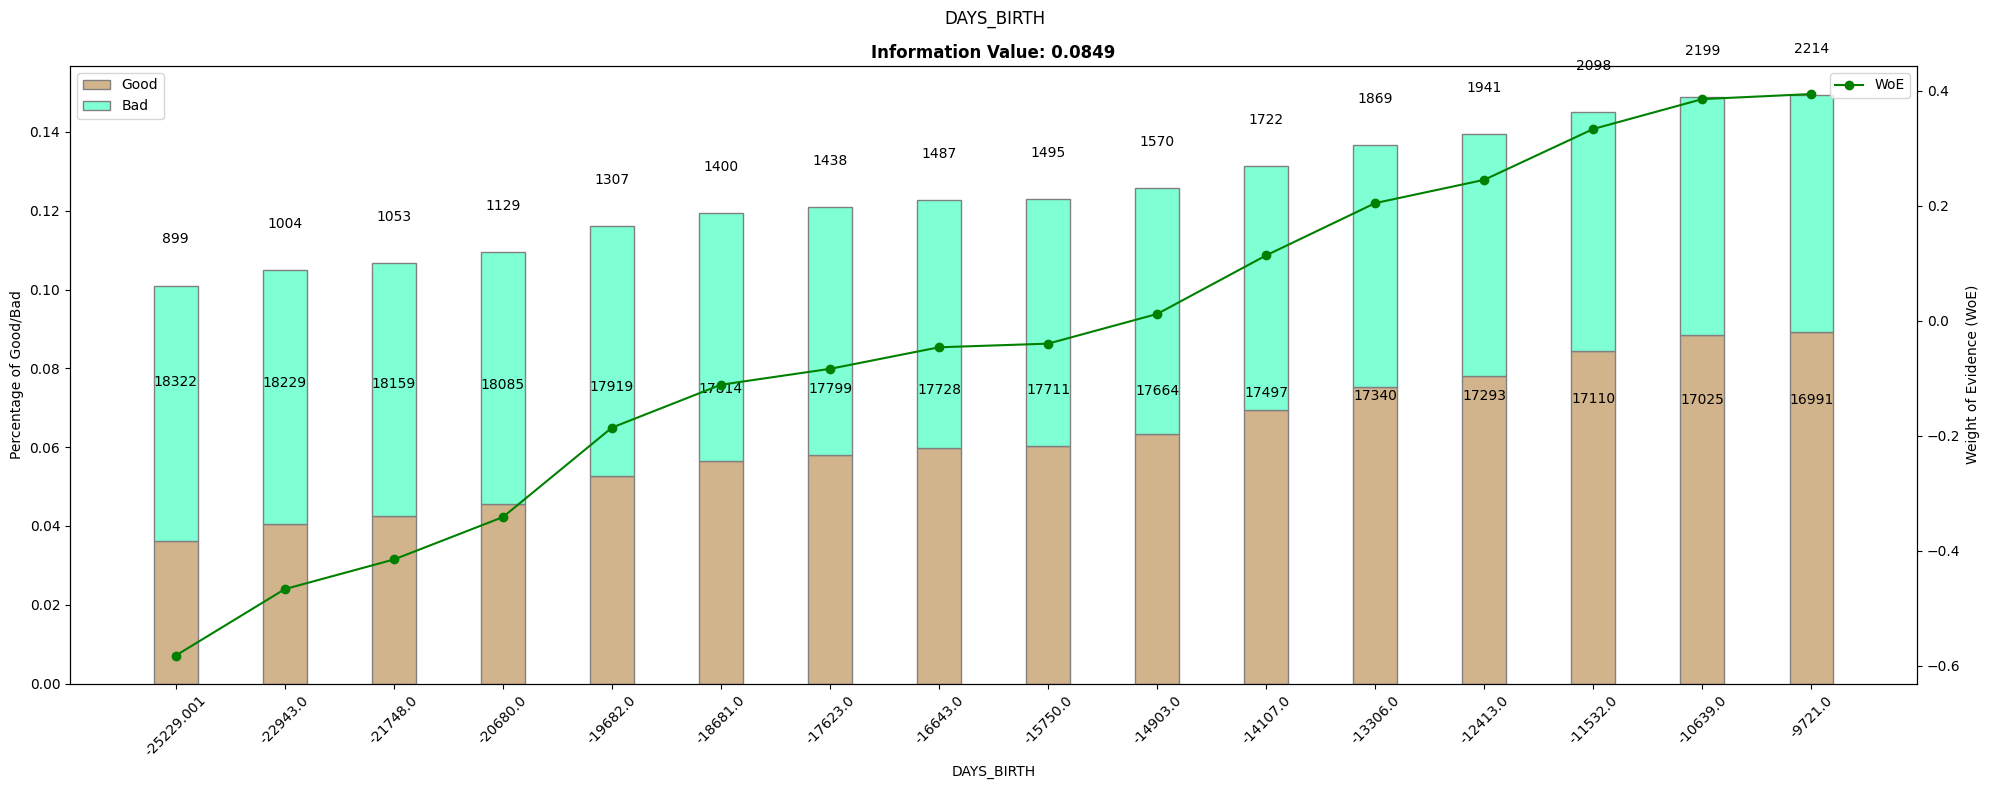

In [126]:
feat_value = ContinuousFeature(df_visualization, "DAYS_BIRTH")
iv_df_4, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_4, 'DAYS_BIRTH', iv_value)

> **OCCUPATION_TYPE**

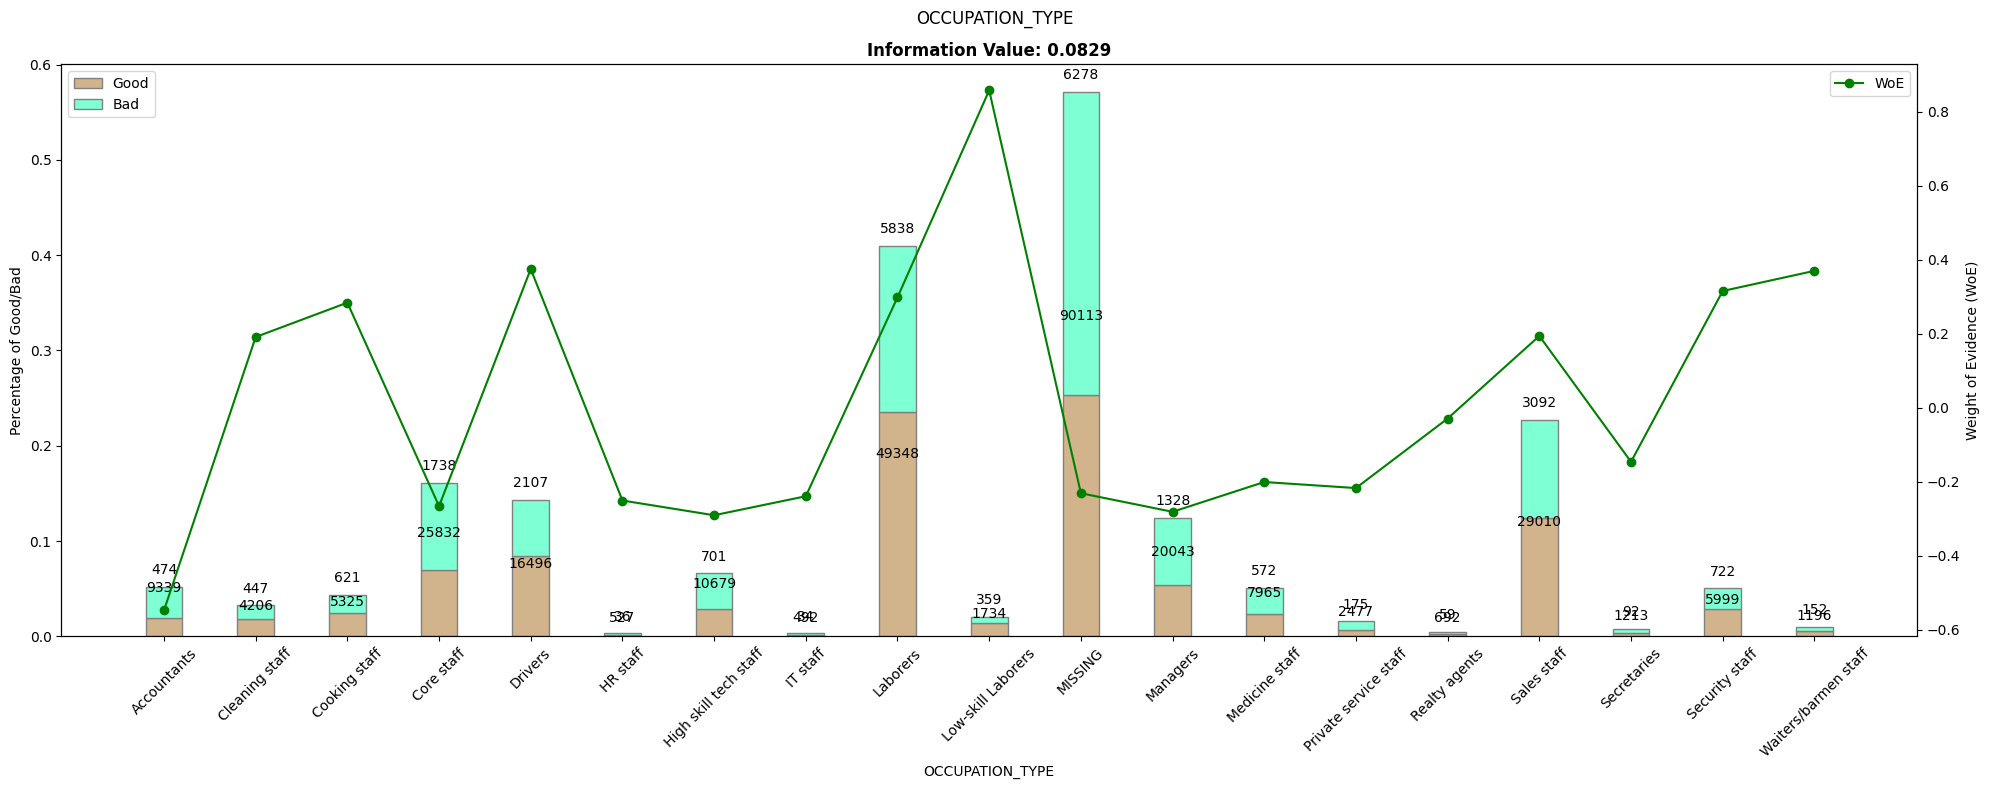

In [127]:
feat_value = CategoricalFeature(df_visualization, "OCCUPATION_TYPE")
iv_df_5, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_5, 'OCCUPATION_TYPE', iv_value)

> **ORGANIZATION_TYPE**

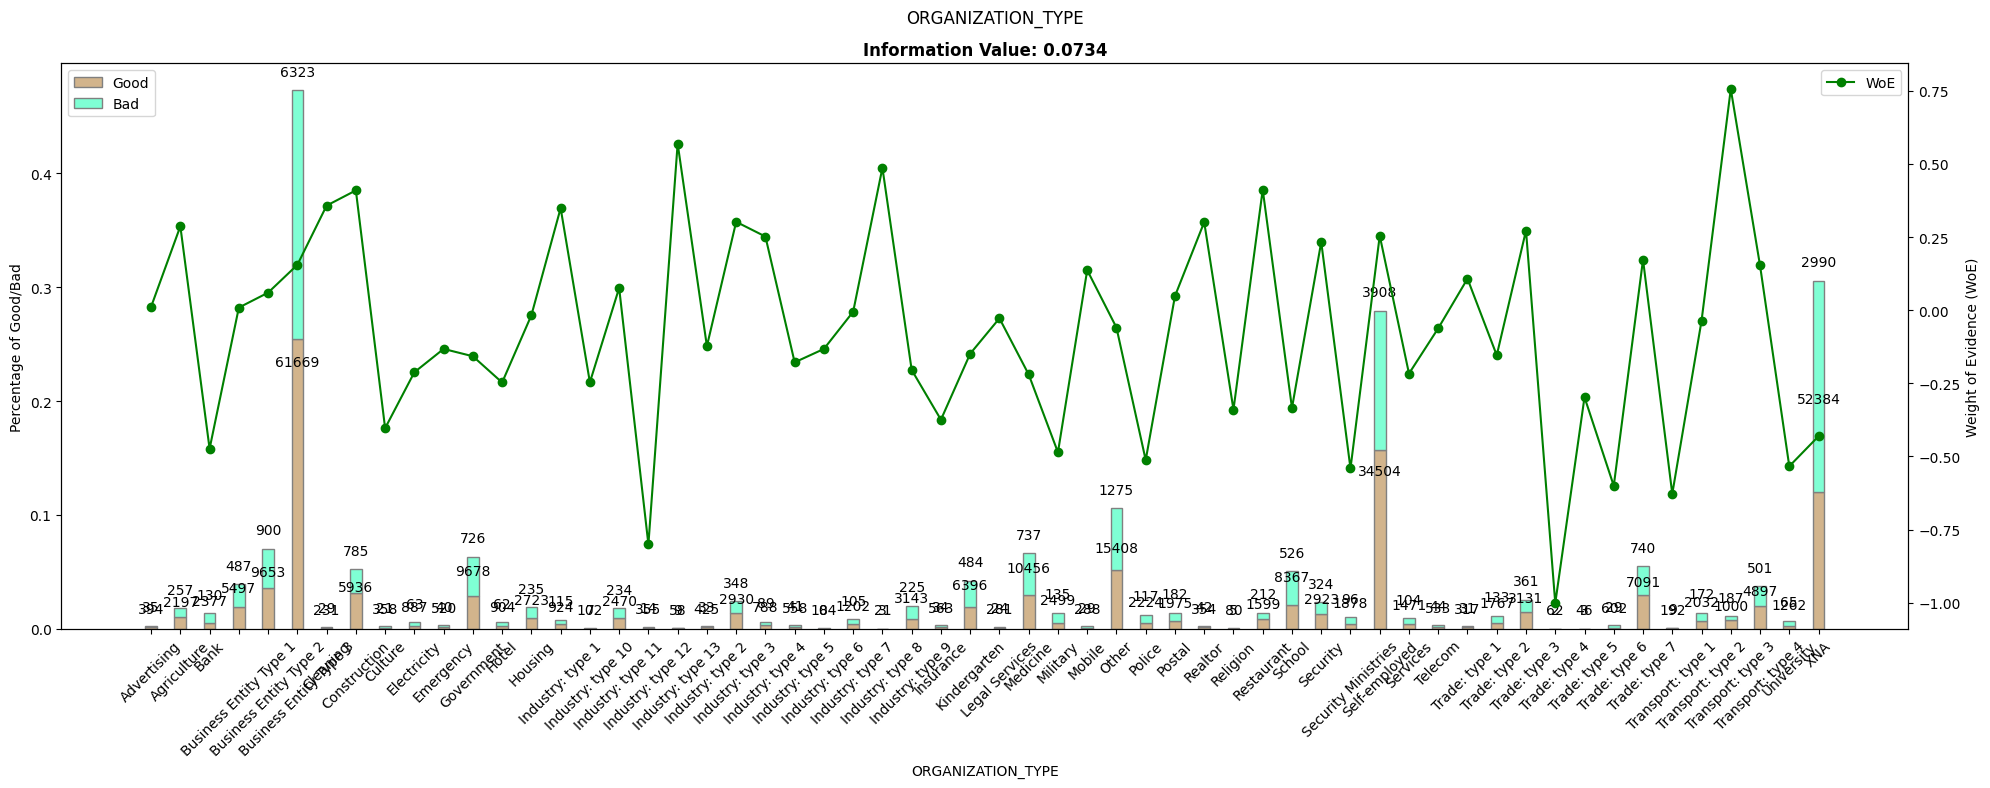

In [128]:
feat_value = CategoricalFeature(df_visualization, "ORGANIZATION_TYPE")
iv_df_6, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_6, 'ORGANIZATION_TYPE', iv_value)

> **NAME_INCOME_TYPE**

In [129]:
feat_value = CategoricalFeature(df_visualization, "NAME_INCOME_TYPE")
iv_df_7, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_7, 'NAME_INCOME_TYPE', iv_value)

> **NAME_EDUCATION_TYPE**

In [130]:
feat_value = CategoricalFeature(df_visualization, "NAME_EDUCATION_TYPE")
iv_df_8, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_8, 'NAME_EDUCATION_TYPE', iv_value)

> **DAYS_LAST_PHONE_CHANGE**

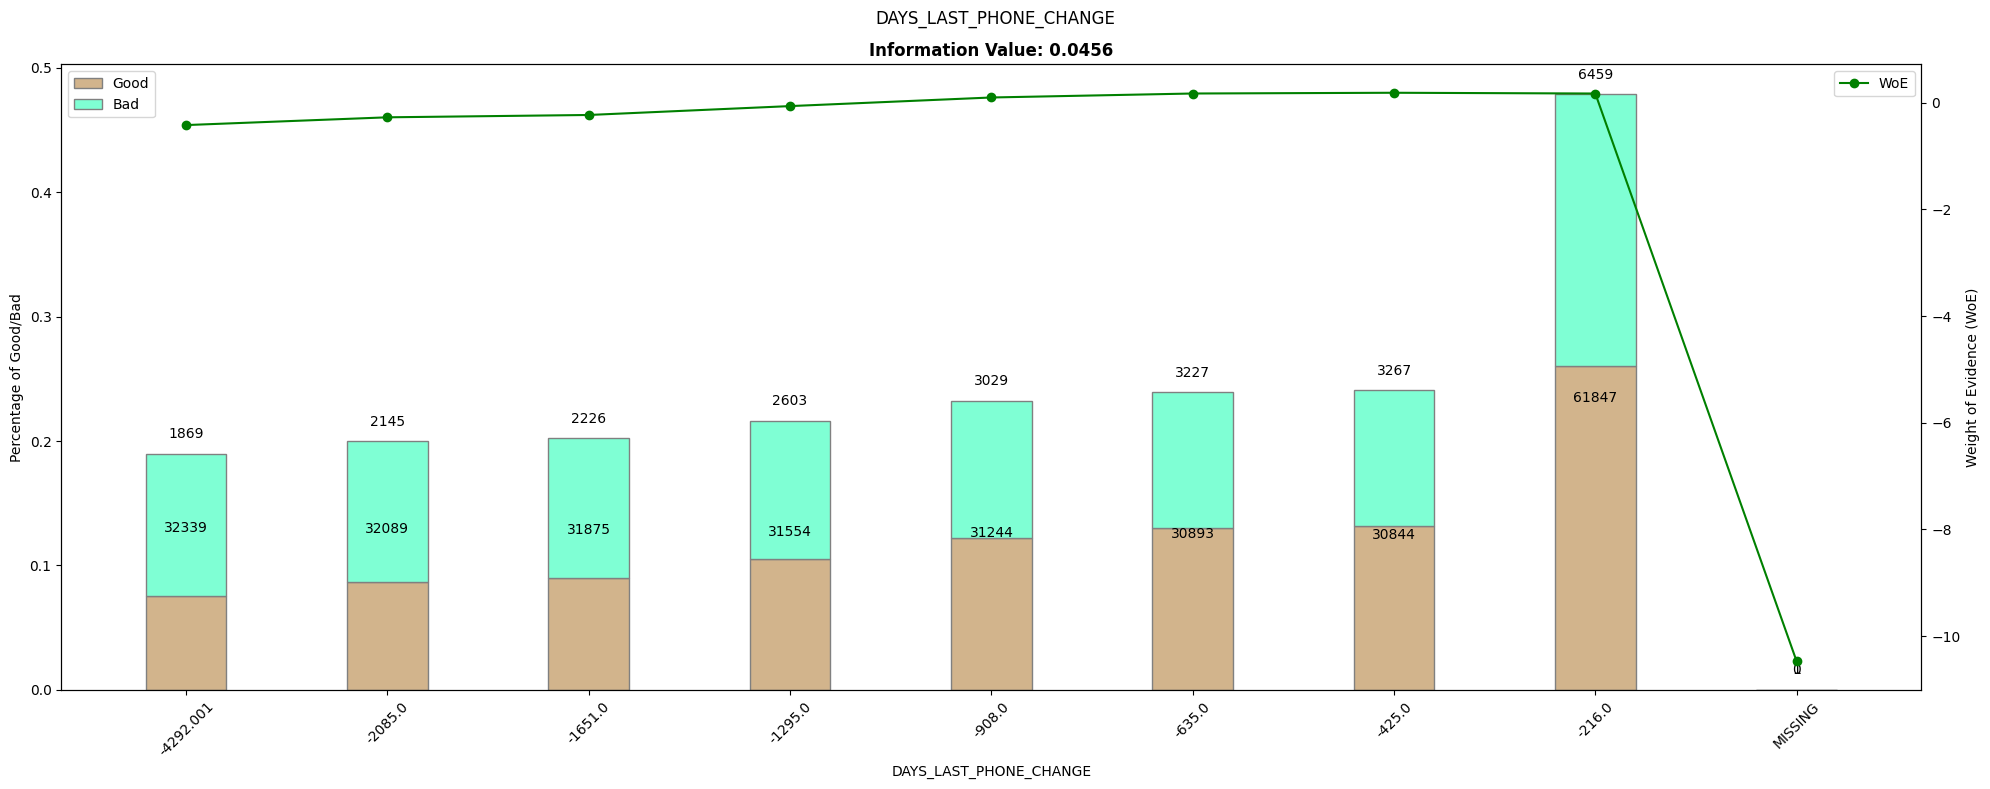

In [131]:
feat_value = ContinuousFeature(df_visualization, "DAYS_LAST_PHONE_CHANGE")
iv_df_9, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_9, 'DAYS_LAST_PHONE_CHANGE', iv_value)

> **DAYS_ID_PUBLISH**

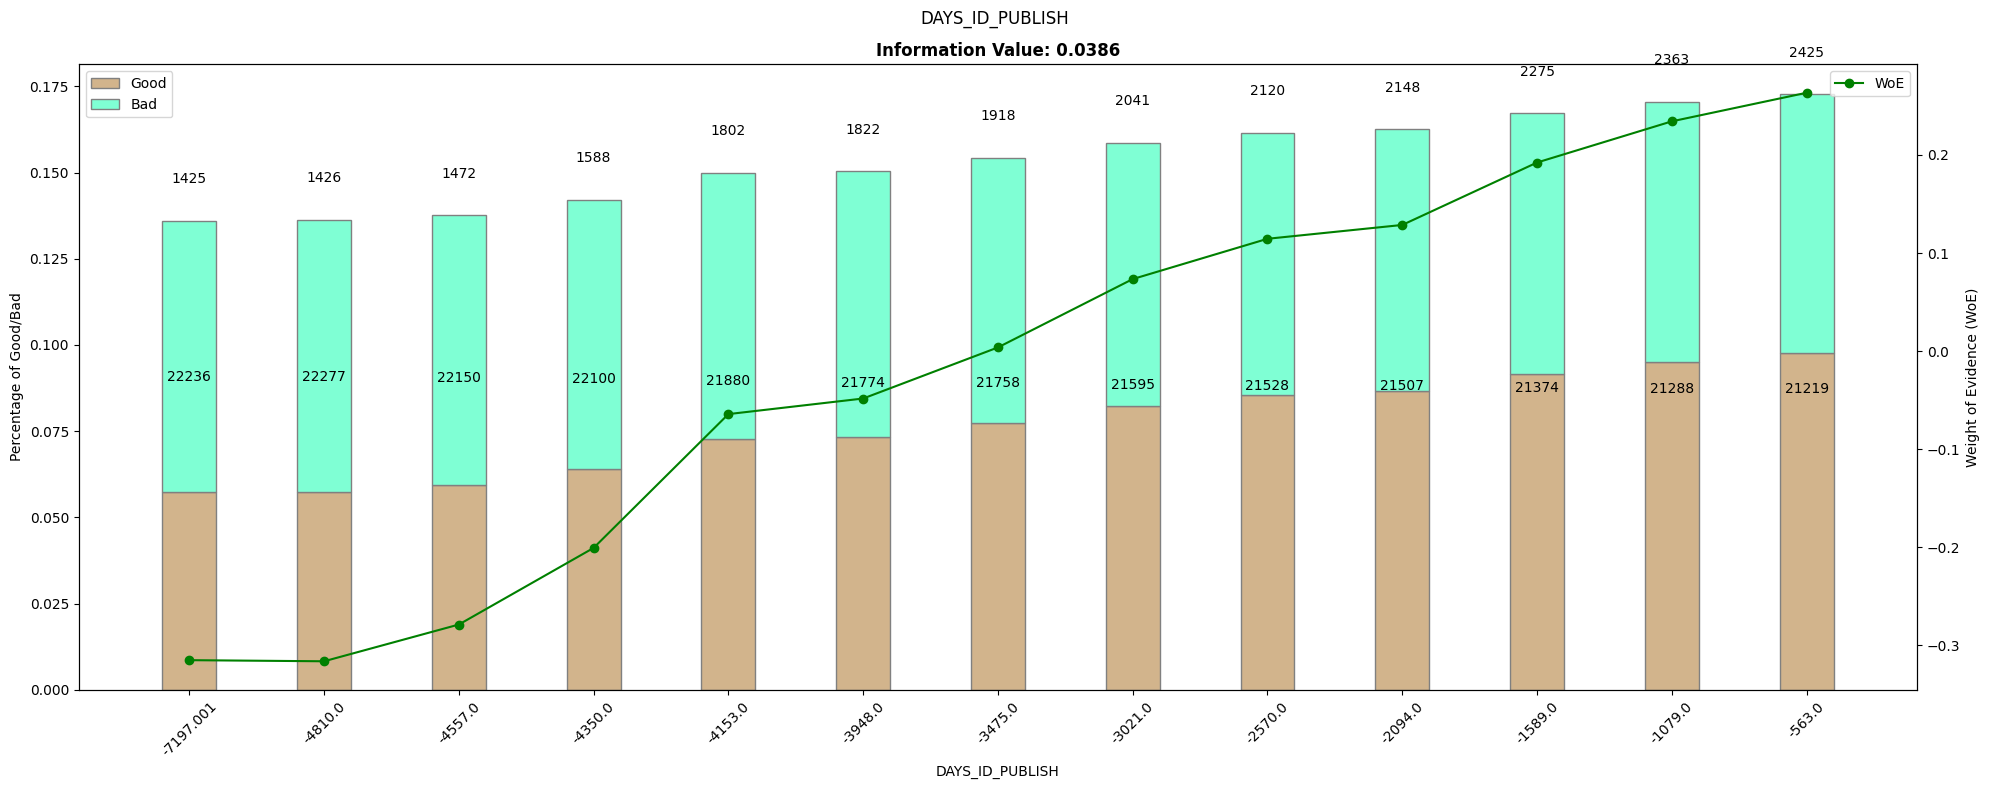

In [132]:
feat_value = ContinuousFeature(df_visualization, "DAYS_ID_PUBLISH")
iv_df_10, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_10, 'DAYS_ID_PUBLISH', iv_value)

> **AMT_GOODS_PRICE**

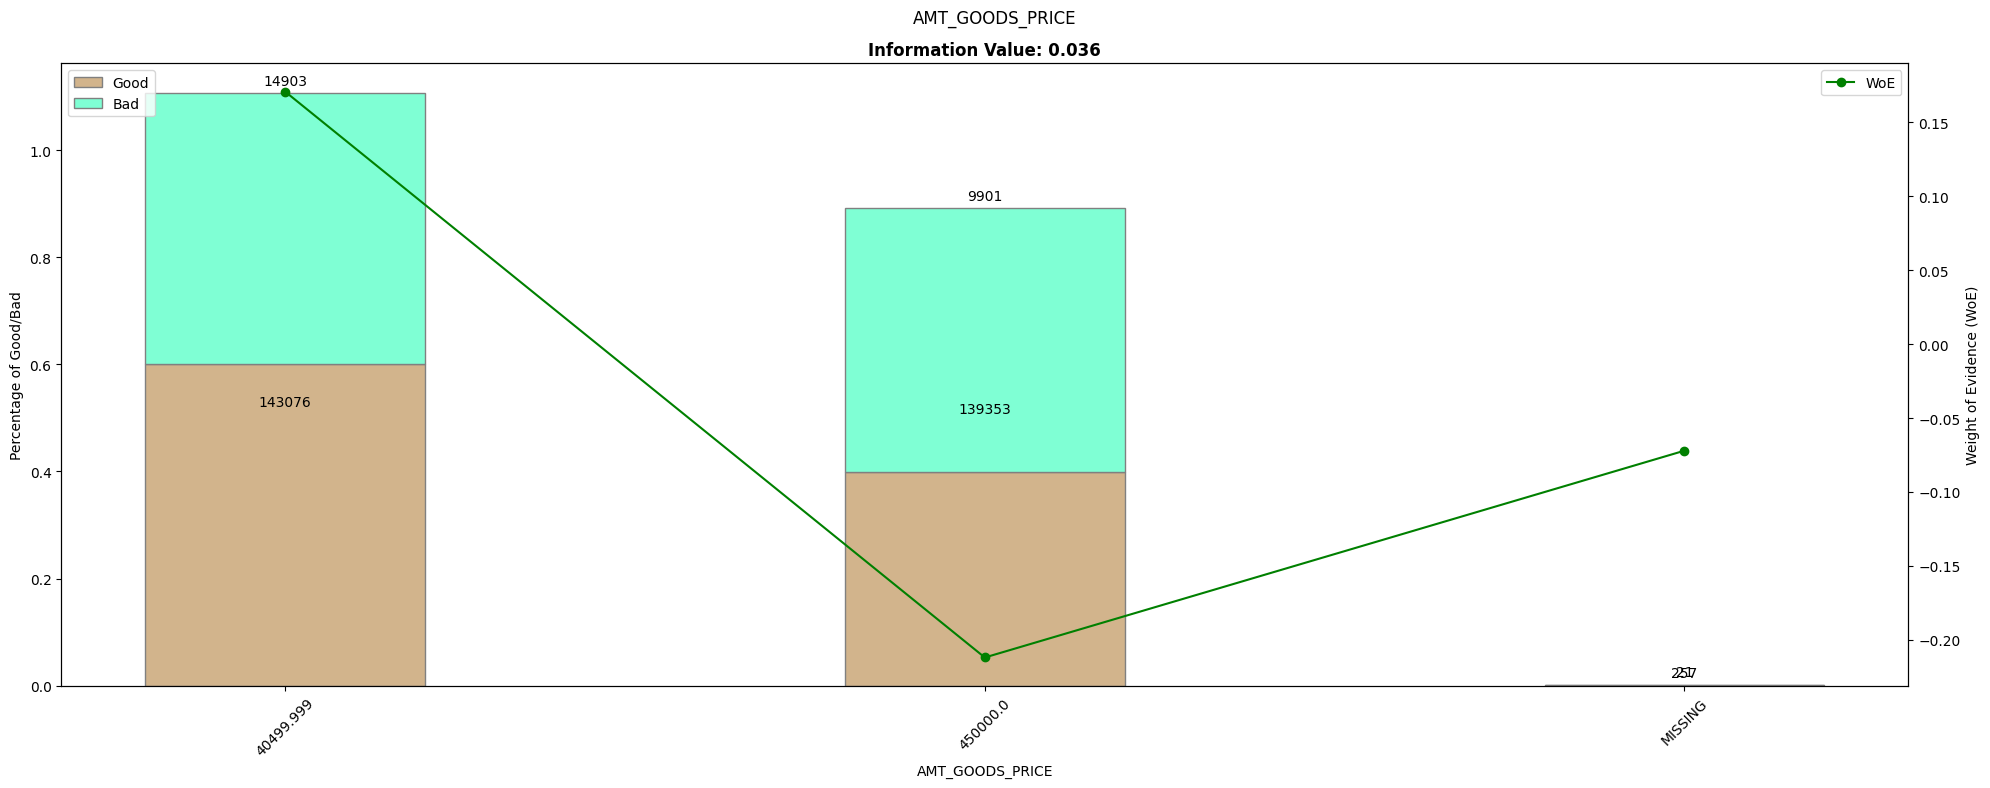

In [133]:
feat_value = ContinuousFeature(df_visualization, "AMT_GOODS_PRICE")
iv_df_11, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_11, 'AMT_GOODS_PRICE', iv_value)

> **TOTALAREA_MODE**


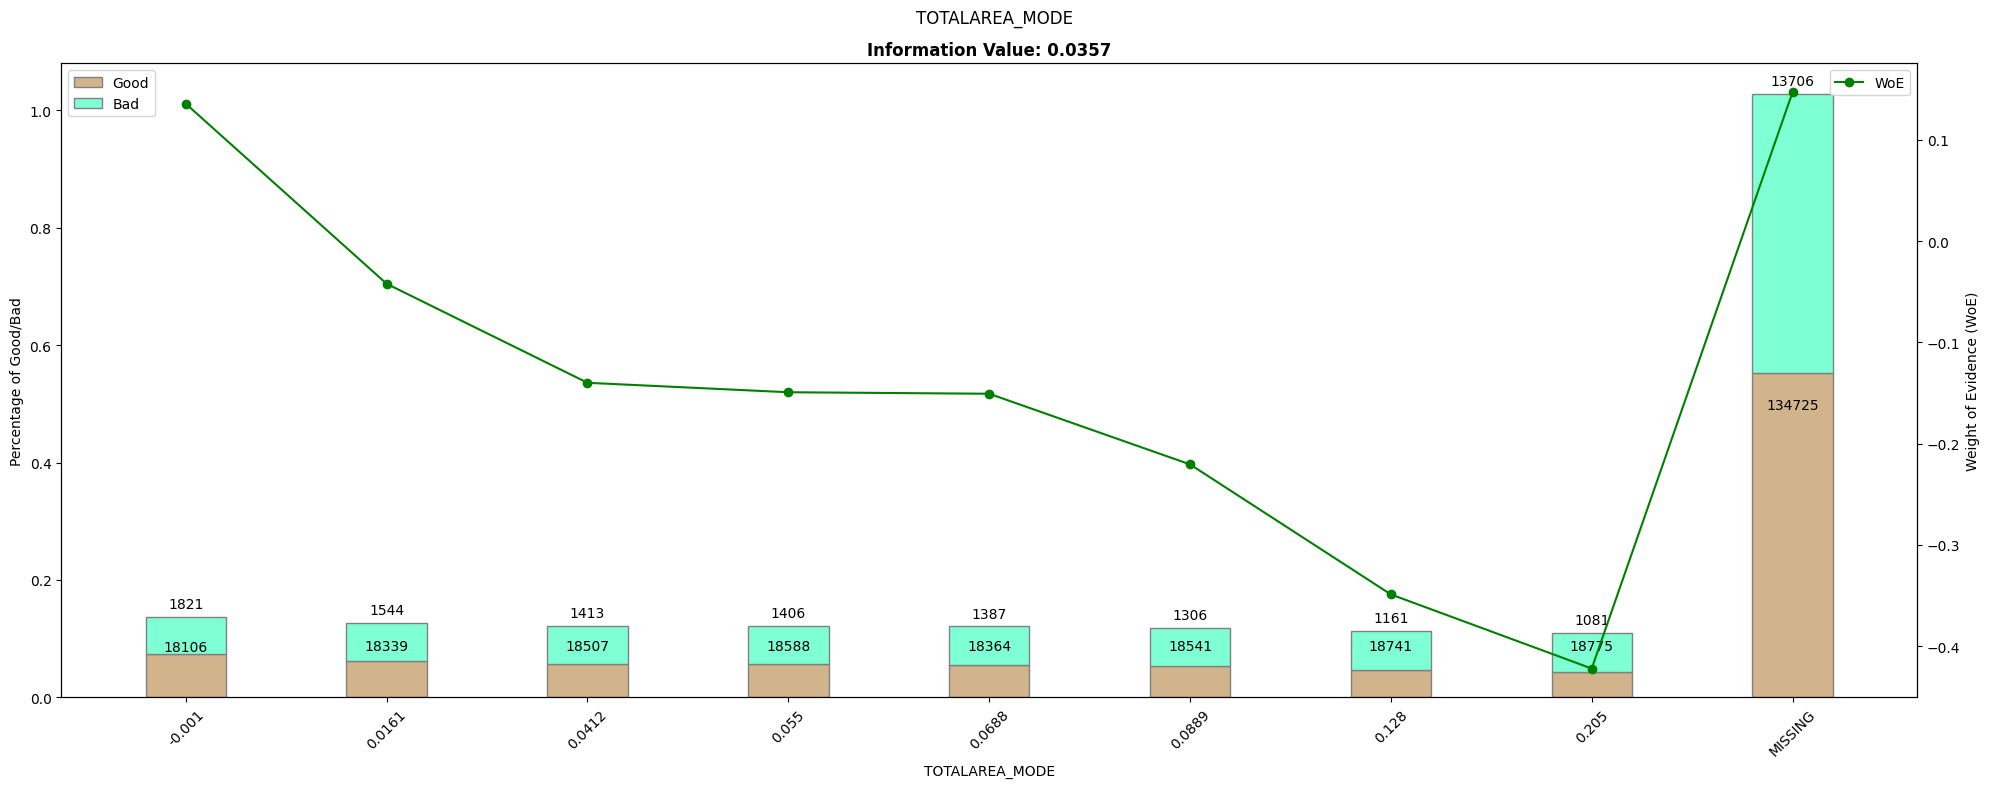

In [134]:
feat_value = ContinuousFeature(df_visualization, "TOTALAREA_MODE")
iv_df_12, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_12, 'TOTALAREA_MODE', iv_value)

> **FLOORSMAX_AVG**

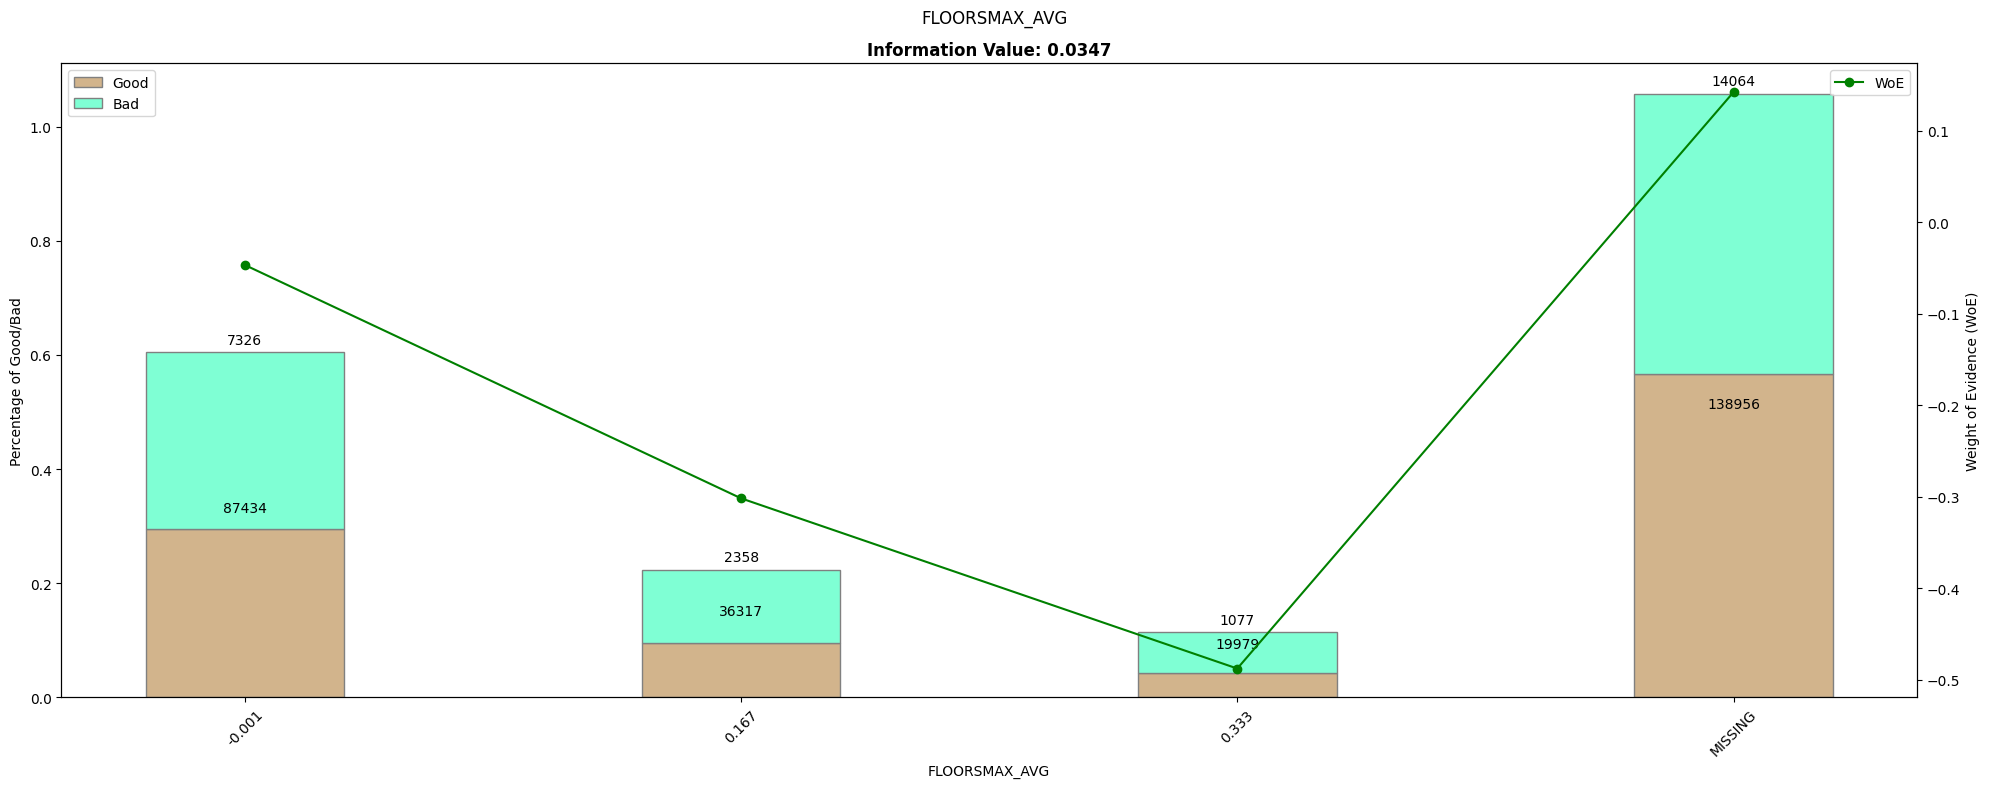

In [135]:
feat_value = ContinuousFeature(df_visualization, "FLOORSMAX_AVG")
iv_df_13, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_13, 'FLOORSMAX_AVG', iv_value)

>**REGION_RATING_CLIENT_W_CITY**

In [136]:
feat_value = CategoricalFeature(df_visualization, "REGION_RATING_CLIENT_W_CITY")
iv_df_14, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_14, 'REGION_RATING_CLIENT_W_CITY', iv_value)

> **EMERGENCYSTATE_MODE**

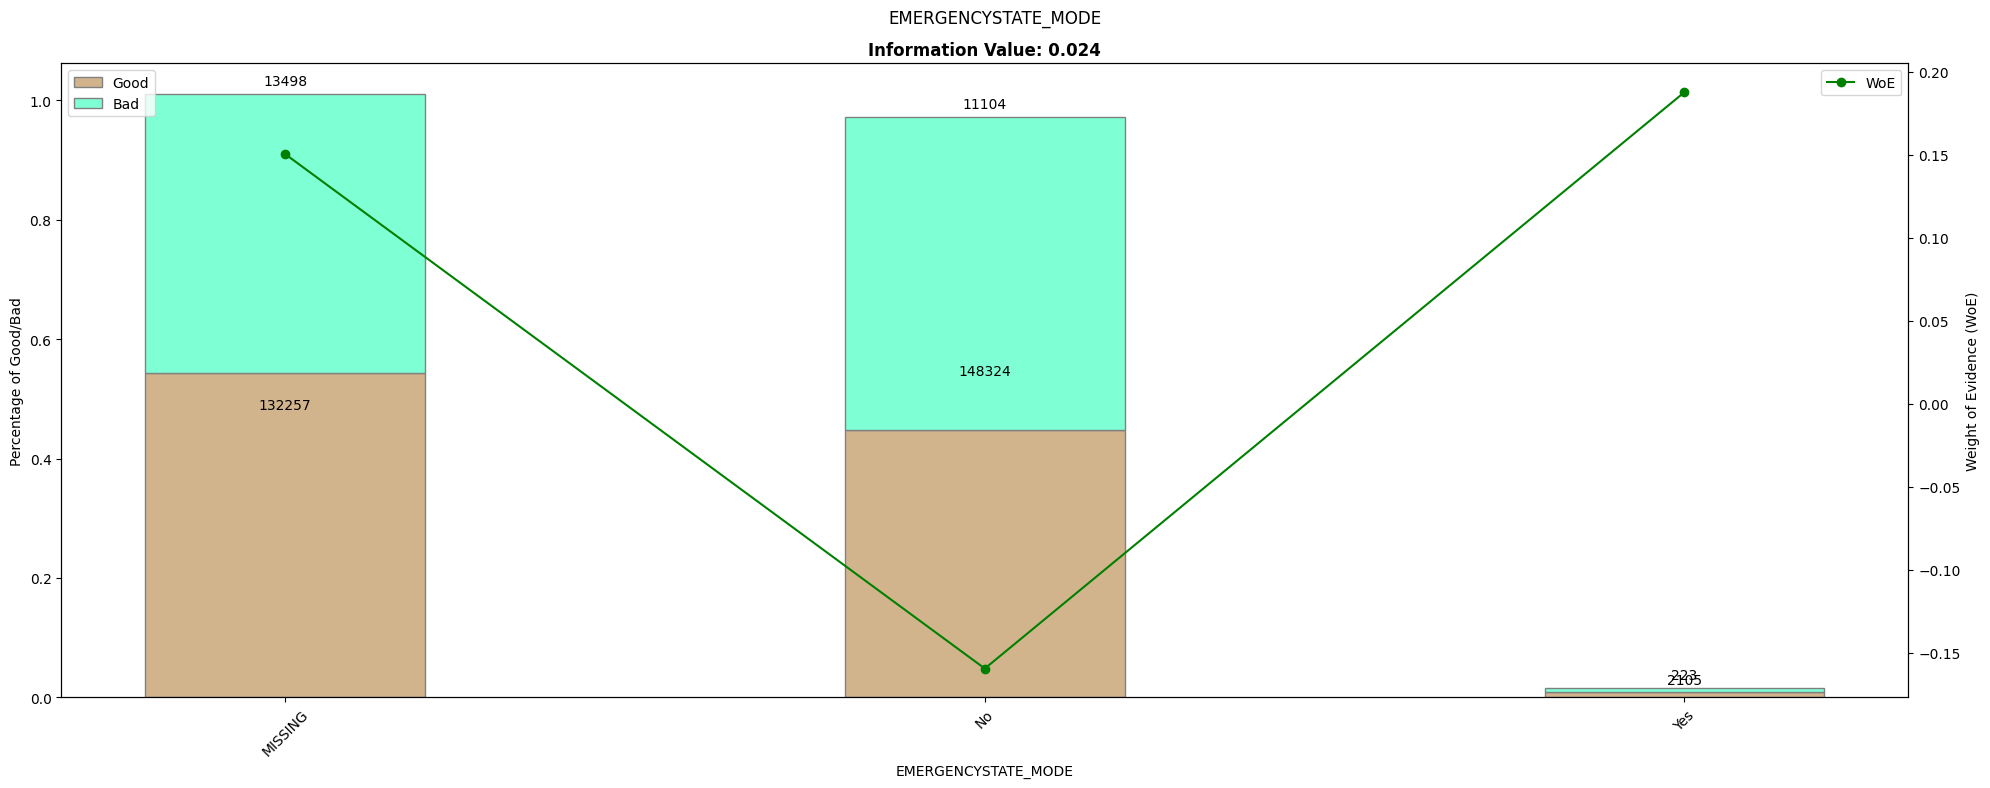

In [137]:
feat_value = CategoricalFeature(df_visualization, "EMERGENCYSTATE_MODE")
iv_df_15, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_15, 'EMERGENCYSTATE_MODE', iv_value)

> **NAME_FAMILY_STATUS**

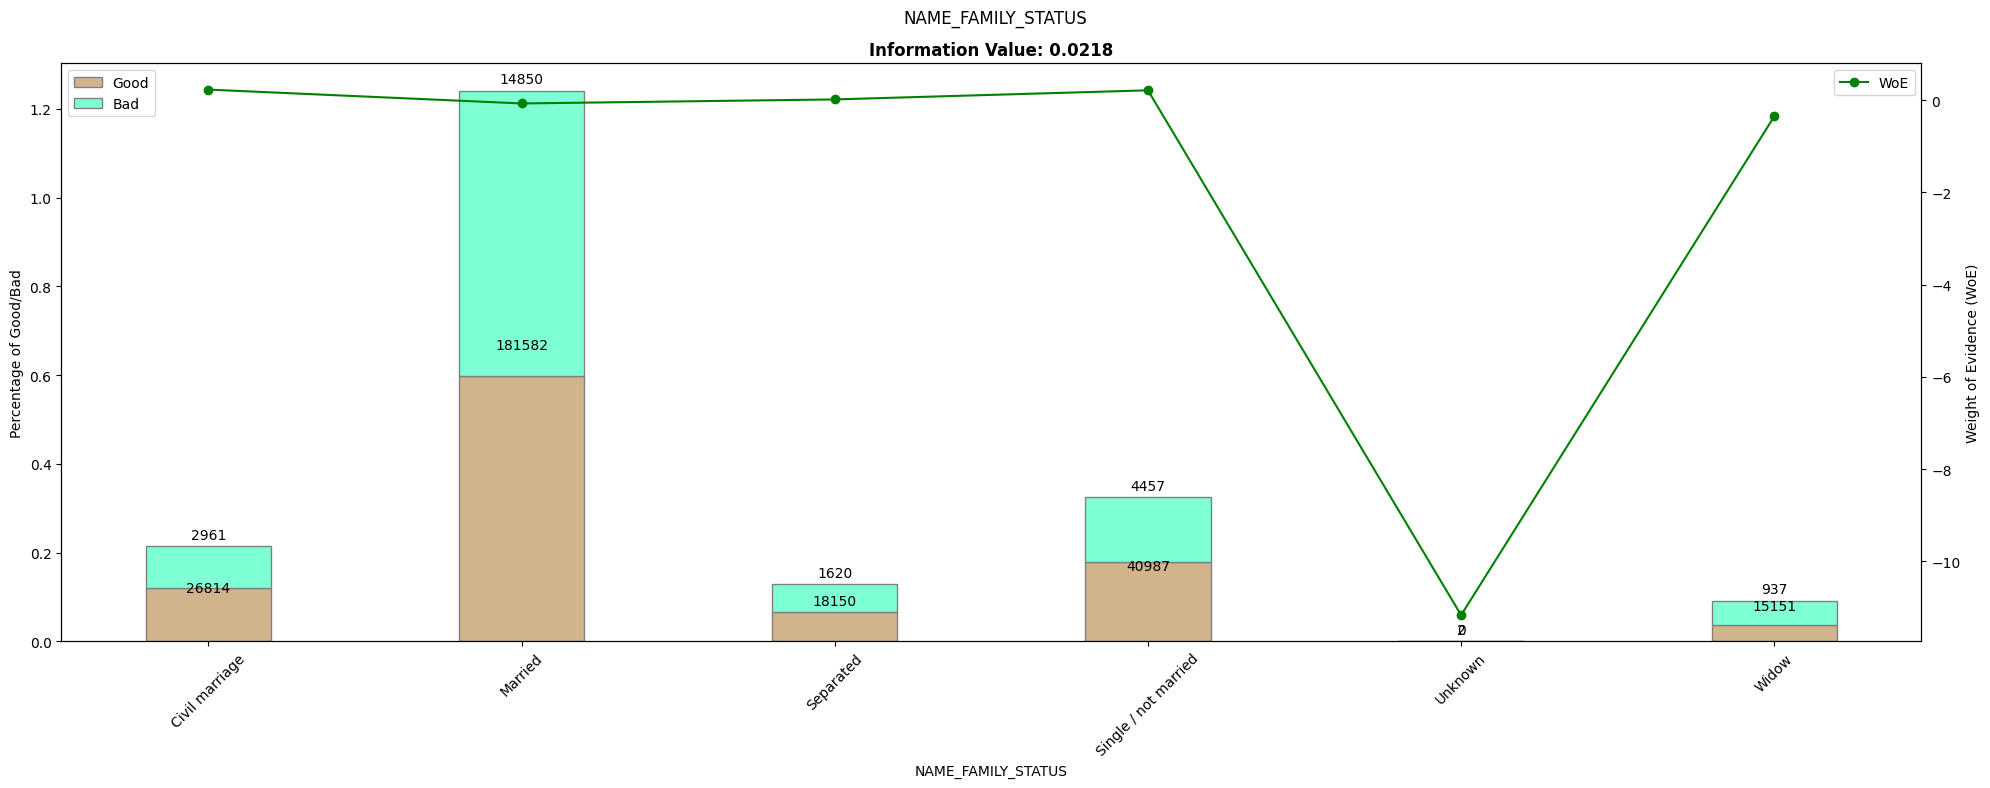

In [138]:
feat_value = CategoricalFeature(df_visualization, "NAME_FAMILY_STATUS")
iv_df_16, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_16, 'NAME_FAMILY_STATUS', iv_value)

> **DAYS_REGISTRATION**

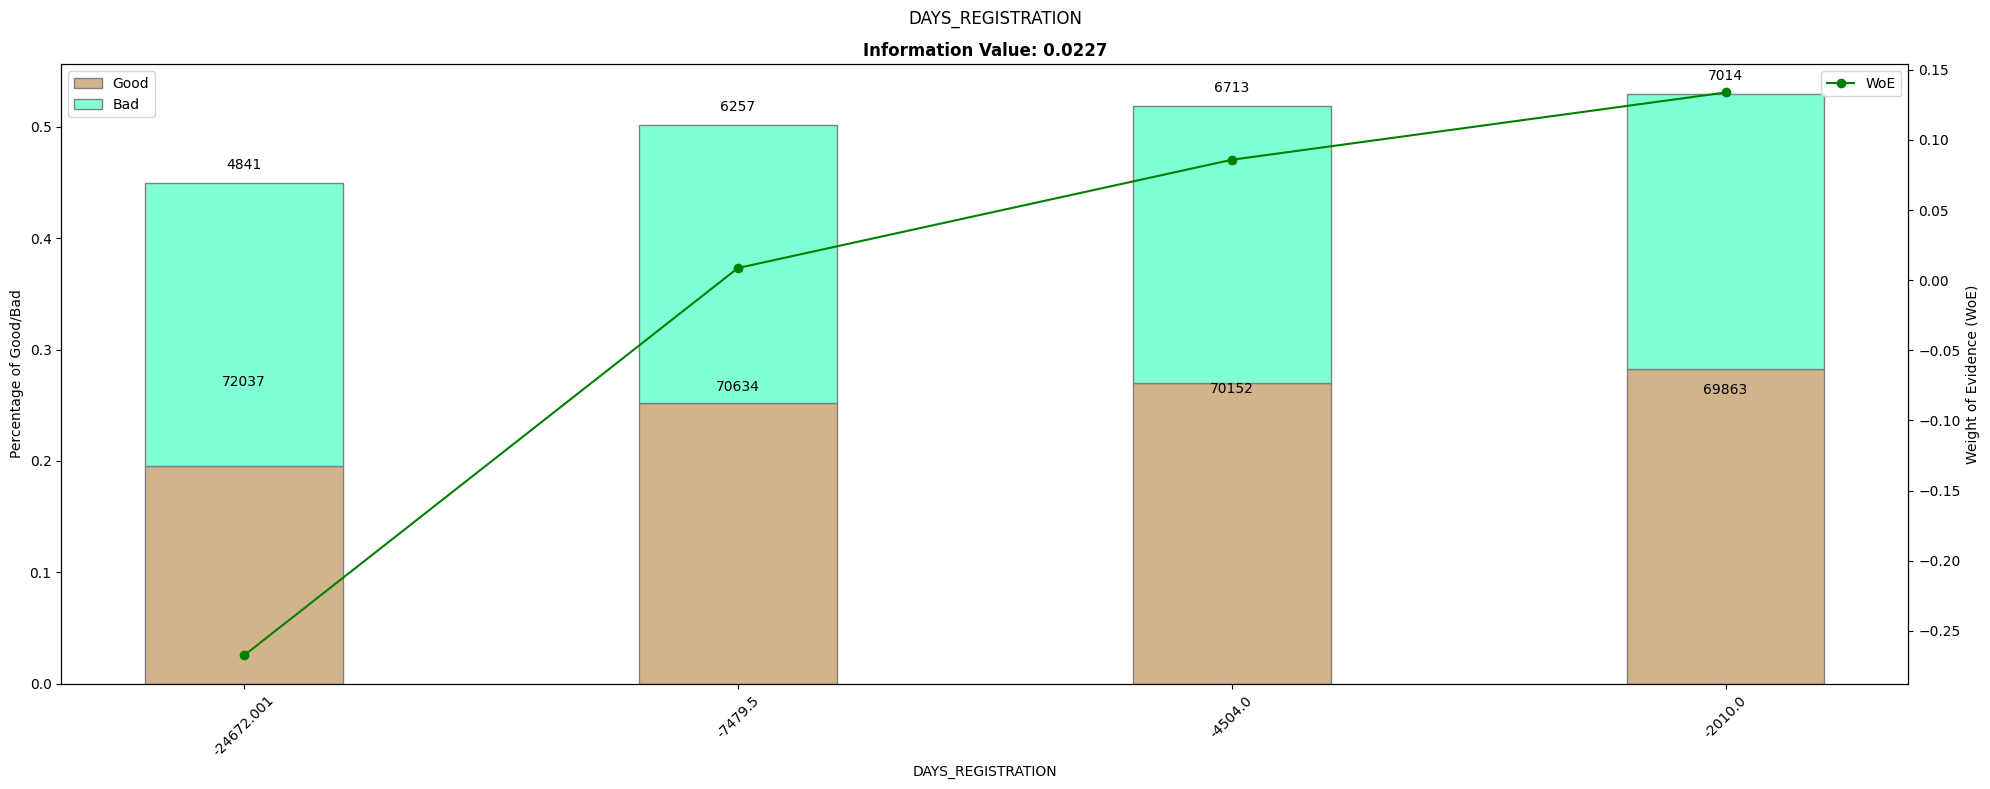

In [139]:
feat_value = ContinuousFeature(df_visualization,  "DAYS_REGISTRATION")
iv_df_17, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_17, 'DAYS_REGISTRATION', iv_value)

> **YEARS_BEGINEXPLUATATION_MEDI**

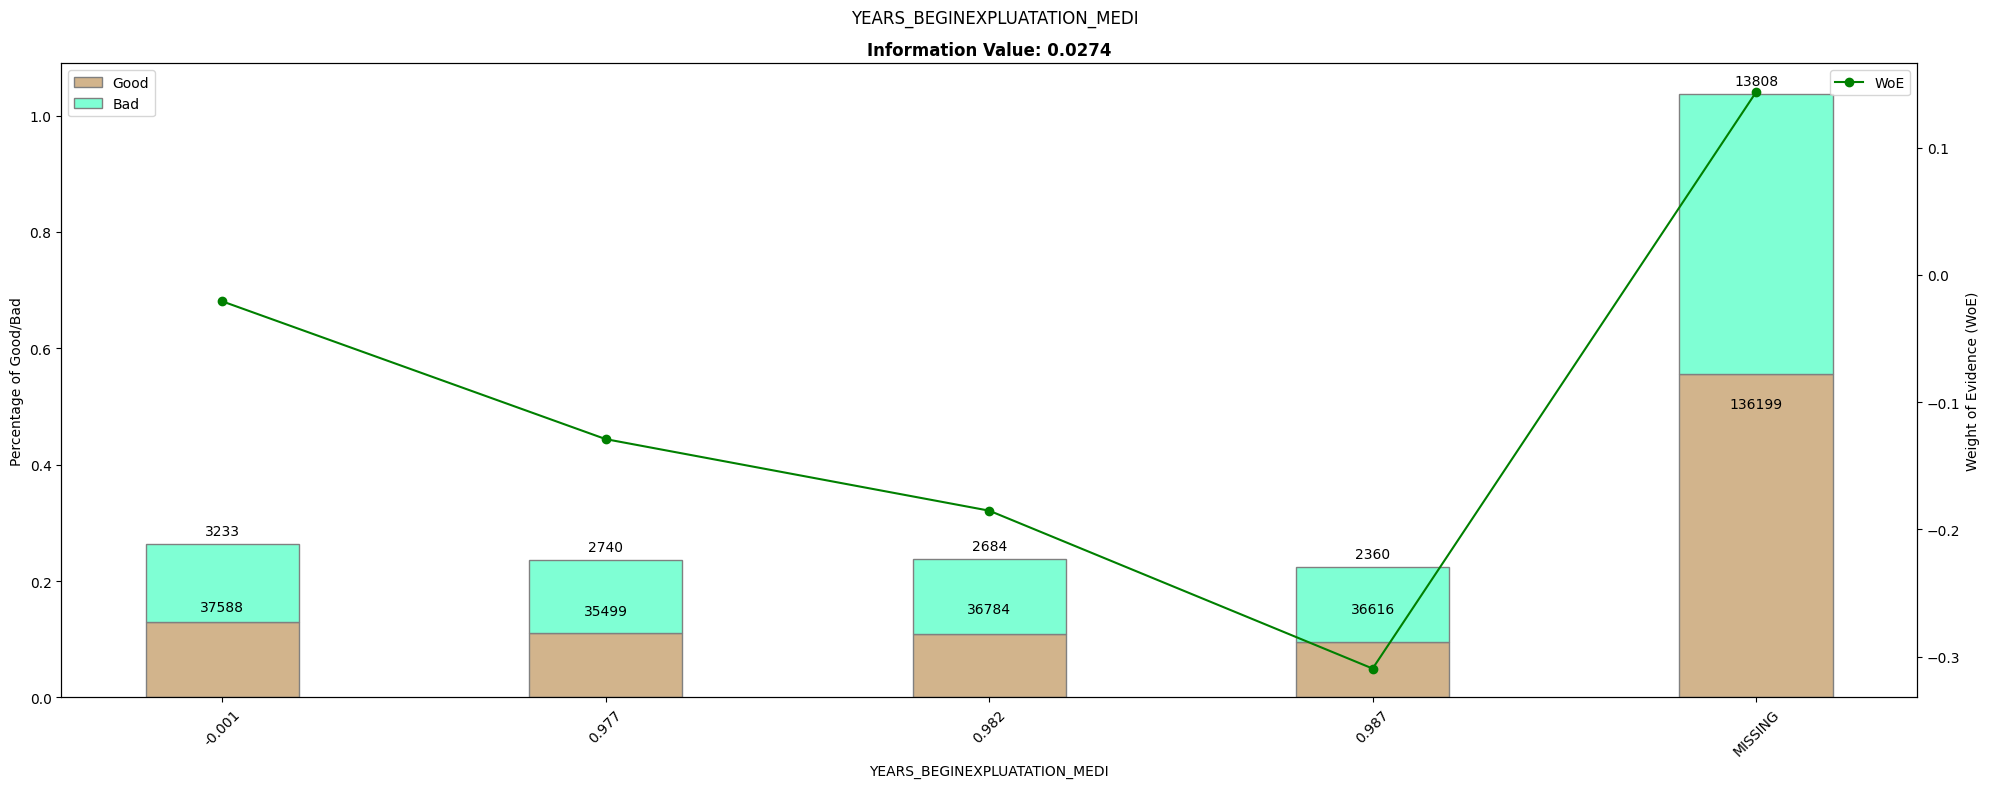

In [140]:
feat_value = ContinuousFeature(df_visualization, "YEARS_BEGINEXPLUATATION_MEDI")
iv_df_18, iv_value = iv.calculate_iv(feat_value)
WOE_Visualization(iv_df_18, 'YEARS_BEGINEXPLUATATION_MEDI', iv_value)

In [143]:
import pandas as pd

# Danh sách chứa các DataFrame
iv_dfs = [iv_df_1, iv_df_2, iv_df_3, iv_df_4, iv_df_5, iv_df_6, iv_df_7,
                    iv_df_8, iv_df_9, iv_df_10, iv_df_11, iv_df_12, iv_df_13, iv_df_14, iv_df_15, iv_df_16, iv_df_17, iv_df_18]

# Ghi vào file Excel
with pd.ExcelWriter("Report Variable.xlsx", engine='xlsxwriter') as writer:
    start_row = 0
    for iv_df in iv_dfs:
        iv_df.to_excel(writer, sheet_name='Sheet1', startrow=start_row, index=False)
        start_row += iv_df.shape[0] + 2


## Logistics Regssion

In [175]:
def Perf_Eva(positive_probs, negative_probs, fpr, tpr, auc, string):
    # Các màu sắc và phong cách được sử dụng
    roc_color = 'darkorange'
    cdf_pos_color = 'blue'
    cdf_neg_color = 'green'
    cdf_line_style = 'step'

    fig, ax = plt.subplots(1, 2, figsize=(20, 7))

    # Biểu đồ CDF
    ax[0].hist(positive_probs, bins=50, alpha=0.5, label='Positive Class',
                cumulative=True, density=True, histtype=cdf_line_style, color=cdf_pos_color)
    ax[0].hist(negative_probs, bins=50, alpha=0.5, label='Negative Class',
                cumulative=True, density=True, histtype=cdf_line_style, color=cdf_neg_color)
    ax[0].set_title('Cumulative Distribution Function (CDF) of Predicted Probabilities')
    ax[0].set_xlabel('Predicted Probability')
    ax[0].set_ylabel('Cumulative Probability')
    ax[0].legend()
    ax[0].grid(True)

    # Biểu đồ ROC
    ax[1].plot(fpr, tpr, color=roc_color, lw=2, linestyle='--', label='ROC curve (area = %0.2f)' % auc)
    ax[1].fill_between(fpr, tpr, color='skyblue', alpha=0.2)  # Thêm vùng màu nhạt
    ax[1].plot([0, 1], [0, 1], '--', color='red')
    ax[1].axis([0, 1, 0, 1])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].legend(loc='lower right')
    ax[1].set_title('ROC Curve')

    plt.tight_layout()
    fig.suptitle(string, fontsize=20, y=1.05)  # Đặt fontsize lớn hơn và thay đổi vị trí y
    plt.show()


In [145]:
train_woe_0 = train_woe[train_woe['label'] == 0].sample(n = 24825, random_state=42)
train_woe_1 = train_woe[train_woe['label'] == 1]
df = pd.concat([train_woe_0, train_woe_1], ignore_index = True)
print(df.shape)
df.head()

(49650, 19)


EXT_SOURCE_3  EXT_SOURCE_2  DAYS_EMPLOYED  DAYS_BIRTH  OCCUPATION_TYPE  \
0     -0.682093     -0.359976       0.364872    0.245387         0.374633   
1     -0.630672     -0.940774      -0.221832   -0.582089        -0.231527   
2      1.137488     -0.553862      -0.215942   -0.185642        -0.281720   
3      0.681580      0.451250       0.243534    0.385805         0.193663   
4      0.049540     -0.553862      -0.215942    0.245387        -0.231527   

   ORGANIZATION_TYPE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0           0.755839          0.188675             0.111494   
1          -0.430842         -0.433445             0.054278   
2           0.154898          0.188675            -0.439594   
3           0.254436         -0.082092             0.111494   
4          -0.204347         -0.082092            -0.439594   

   DAYS_LAST_PHONE_CHANGE  DAYS_ID_PUBLISH  AMT_GOODS_PRICE  TOTALAREA_MODE  \
0                0.173296         0.003787        -0.211889       -0.422154   
1                0.173296        -0.064190        -0.211889       -0.139948   
2               -0.229130         0.114547         0.170672       -0.422154   
3                0.187415         0.003787         0.170672        0.147084   
4                0.173296        -0.200617        -0.211889        0.147084   

   FLOORSMAX_AVG  REGION_RATING_CLIENT_W_CITY  YEARS_BEGINEXPLUATATION_MEDI  \
0      -0.488017                     0.382184                     -0.309338   
1      -0.301987                    -0.077080                     -0.020789   
2      -0.488017                    -0.077080                     -0.309338   
3       0.141947                    -0.077080                      0.143617   
4       0.141947                    -0.077080                      0.143617   

   EMERGENCYSTATE_MODE  DAYS_REGISTRATION  NAME_FAMILY_STATUS  label  
0            -0.159608           0.133858           -0.071222      0  
1            -0.159608           0.085867           -0.071222      0  
2            -0.159608           0.008675           -0.350653      0  
3             0.150280           0.008675            0.213706      0  
4             0.150280           0.133858           -0.071222      0

> **Train Test Split**

In [146]:
X = df.drop('label', axis = 1)
y = df['label']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (39720, 18)
X_test shape:  (9930, 18)
y_train shape:  (39720,)
y_test shape:  (9930,)


**Model Train**

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.001, 0.01, 1, 3, 10, 20],
    'penalty': ['l1', 'l2'],
    'class_weight' : ['balanced'],
    'max_iter': [100, 200, 300],
    'solver' : ['liblinear', 'saga']
}

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid, cv = kf, scoring='roc_auc', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (ROC AUC):", best_score)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Score (ROC AUC): 0.7303592950128608


In [149]:
logit_model = LogisticRegression(C = 1, solver = 'saga', class_weight = 'balanced', max_iter= 300, fit_intercept = True, penalty='l1')
logit_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=300, penalty='l1',
                   solver='saga')

**Model Evaluate**

> **Evaluate - Test**

Kolmogorov-Smirnov: 0.347
ROC curve: 0.7354


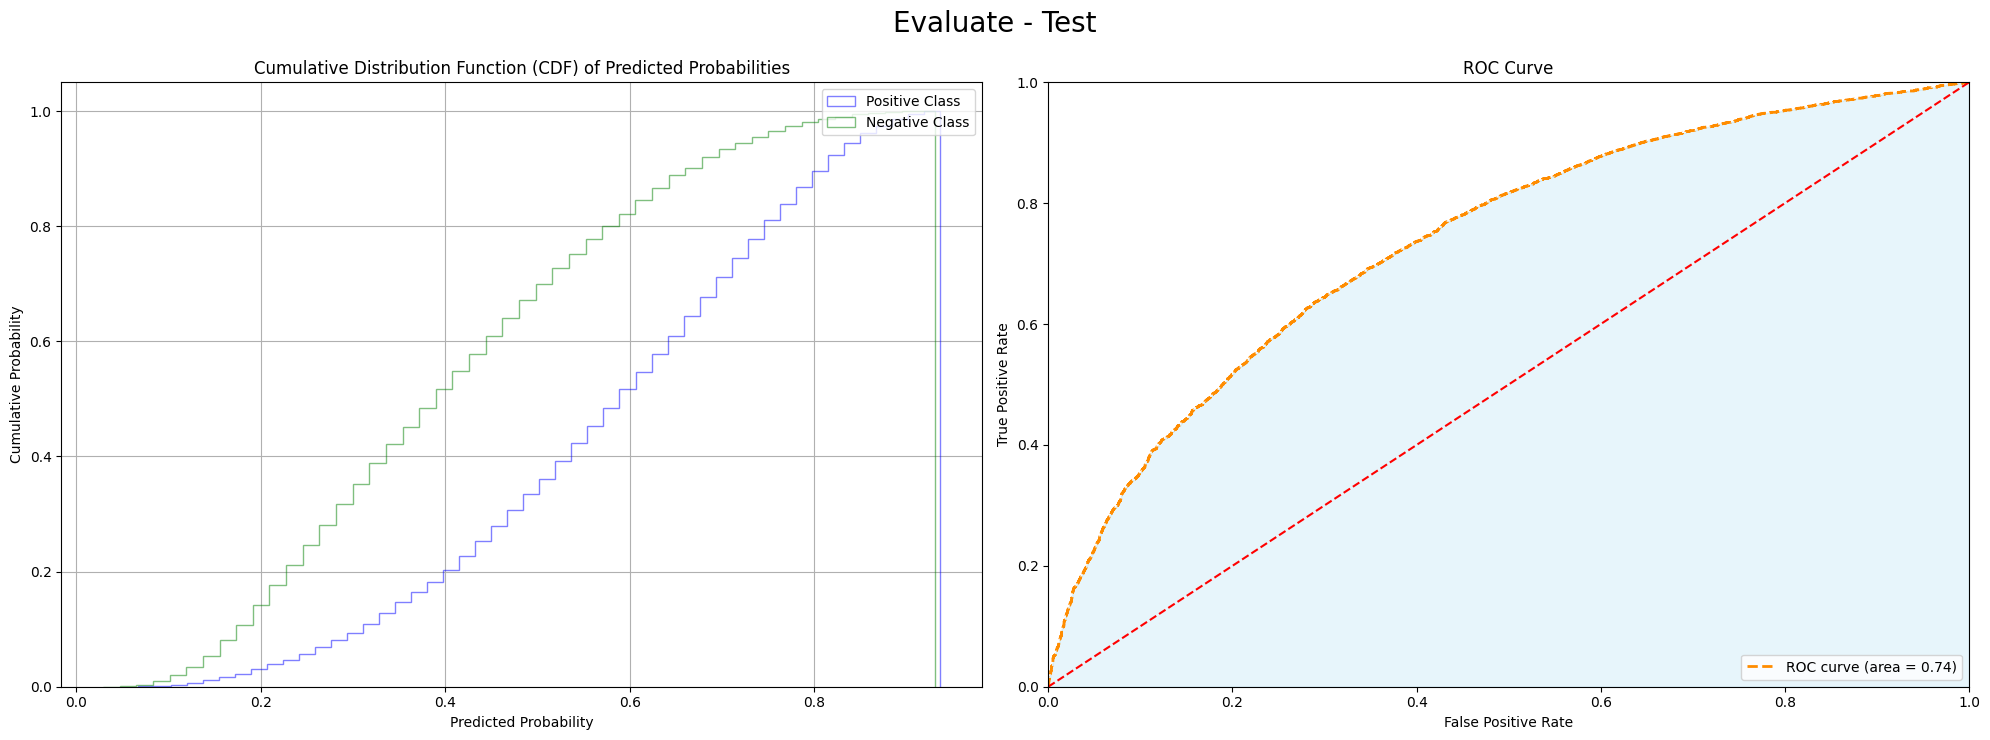

In [180]:
from scipy.stats import ks_2samp
y_pred_proba = logit_model.predict_proba(X_test)[:, 1]

positive_probs = y_pred_proba[y_test == 1]
negative_probs = y_pred_proba[y_test == 0]

ks_statistic, p_value = ks_2samp(positive_probs, negative_probs)
print("Kolmogorov-Smirnov:", round(ks_statistic, 4))

fpr, tpr, thres = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC curve:",  round(roc_auc, 4))

Perf_Eva(positive_probs, negative_probs, fpr, tpr, roc_auc, "Evaluate - Test")

> **Evaluate - Train**

Kolmogorov-Smirnov: 0.3437
ROC curve: 0.7309


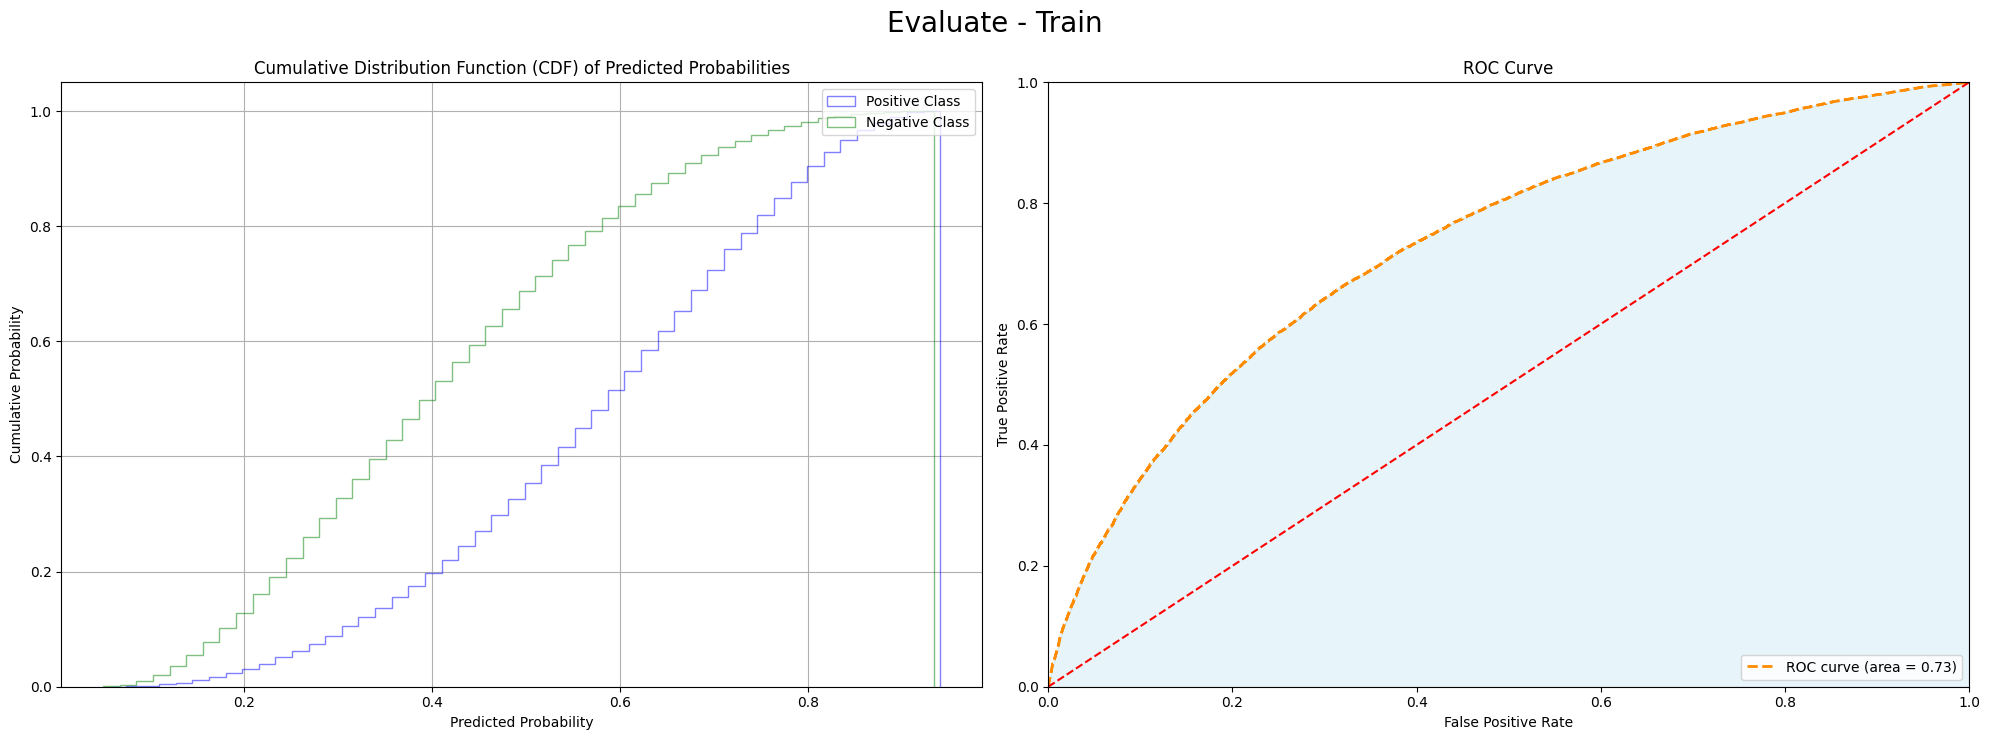

In [181]:
y_pred_proba = logit_model.predict_proba(X_train)[:, 1]

positive_probs = y_pred_proba[y_train == 1]
negative_probs = y_pred_proba[y_train == 0]

ks_statistic, p_value = ks_2samp(positive_probs, negative_probs)
print("Kolmogorov-Smirnov:", round(ks_statistic, 4))

fpr, tpr, thres = roc_curve(y_train, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC curve:",  round(roc_auc, 4))

Perf_Eva(positive_probs, negative_probs, fpr, tpr, roc_auc, "Evaluate - Train")